In [1]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut
import functions

import time

import constants as ct

In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    #tank_current_loads = tank_max_loads.copy()
    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load 
    #tank_current_loads = tank_max_loads.copy()
    

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
#print([load for load in system.tank_loads])
print(system.graph)
print(system.weights)

[77, 143, 40, 307, 122]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  32.  159.  162.  156.  156.    0.]]


In [5]:
tanks[0].level_percentages

array([ 0.02,  0.31,  0.9 ])

### Reinitialize system function

In [6]:
verbose = False
print(system.tank_loads())
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

system = reinitialize_system(system,3)
print(system.tank_loads())
system = reinitialize_system(system,4)
print(system.tank_loads())
reward = system.random_action(seed = 1, verbose = verbose)
system.reset_trucks_positions();
#print(reward)
reward = system.random_action(seed = 1, verbose = verbose)
#print(reward)

[77, 143, 40, 307, 122]
[50.0, 182.0, 82.0, 457.0, 72.0]
[72.0, 180.0, 98.0, 594.0, 109.0]


## Q-learning algorithm (off-policy)


### Training

In [7]:
# Train parameters:
retrain = False
train_epsilon = False

learning_rate0 = 1 #0.05
learning_rate_decay = 0 #0.01

episodes = 11*10**3 #episodes
episodes_epsilon_min = 10**4/10 #5*10*6
train_freq = 10**3 # 10**4
train_vis_freq =  10**3
train_rew_freq =  10**3
episode_length = 30

discount_rate = 1

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 18

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print("Episode ", episode, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
                    
                ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
            #rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, "discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True:
    #train_Q_epsilon()
    episodic_train_Q_epsilon()

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system(seed =100000)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#Load trained Q-values
# if train == False:
#     simulation_id = 8
#     train_iterations = 20*10**5
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


# if retrain == False:
#     simulation_id = 7
#     train_iterations = 259*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

   
#test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
if train_epsilon == False:
    simulation_id = 18
    episodes =11000
    
Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1000
episode_length =30
test_freq = 1
test_verbose = True

test_visualization_steps = []
test_rewards_list = []

In [12]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            #if i % freq == 0:
                #visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("Some tank is in a forb10**3Pidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


In [13]:
test_Q()
print(np.mean(test_rewards_list) )



Episode 1 t 0 24.7807928594 4500
Episode 1 t 1 26.6890017701 5500
Episode 1 t 2 21.524908251 5500
Episode 1 t 3 4.32500024755 4300
Episode 1 t 4 18.713024756 0500
Episode 1 t 5 6.59456144334 4300
Episode 1 t 6 0.205125630203 3300
Episode 1 t 7 4.90526687316 2400
Episode 1 t 8 11.351903852 4500
Episode 1 t 9 22.2320543187 0300
Episode 1 t 10 10.5262260548 3300
Episode 1 t 11 14.3647075043 5500
Episode 1 t 12 7.29645563767 4500
Episode 1 t 13 6.26186345205 0300
Episode 1 t 14 -0.403567749524 2300
Episode 1 t 15 10.9105281552 4500
Episode 1 t 16 5.07699856364 0300
Episode 1 t 17 16.0215681984 5400
Episode 1 t 18 7.03102972835 1300
Episode 1 t 19 -0.0883586355873 3300
Episode 1 t 20 8.73213350575 4500
Episode 1 t 21 8.82445923138 0300
Episode 1 t 22 16.7729121069 2500
Episode 1 t 23 11.0281570406 4500
Episode 1 t 24 -3.34120331378 3300
Episode 1 t 25 14.6034649822 0400
Episode 1 t 26 4.98199456019 3300
Episode 1 t 27 6.05885969854 2500
Episode 1 t 28 2.535914967 4300
Episode 1 t 29 2.40233

Episode 9 t 19 24.902547325 0500
Episode 9 t 20 5.50043330872 3300
Episode 9 t 21 10.6188194821 5400
Episode 9 t 22 4.53759852564 5300
Episode 9 t 23 16.0479318552 0500
Episode 9 t 24 -993.622962611 2400
Episode 9 t 25 5.23512951062 3300
Episode 9 t 26 4.07358395623 3300
Episode 9 t 27 20.7755971397 0500
Episode 9 t 28 12.7055902779 4500
Episode 9 t 29 -4.23032970037 3300
Episode 10 t 0 -1199.23698358 4500
Episode 10 t 1 23.4599788 0500
Episode 10 t 2 17.1950885181 0500
Episode 10 t 3 16.5089398942 5400
Episode 10 t 4 -1067.20622295 5500
Episode 10 t 5 15.0018456523 2500
Episode 10 t 6 13.5763651936 4500
Episode 10 t 7 -2150.20981252 1300
Episode 10 t 8 16.7012916863 0500
Episode 10 t 9 -2.86848106014 3300
Episode 10 t 10 3.23735506478 2400
Episode 10 t 11 18.4979198404 0300
Episode 10 t 12 24.2754441046 4500
Episode 10 t 13 6.58505984065 3300
Episode 10 t 14 13.7443680461 4500
Episode 10 t 15 3.35334946964 5300
Episode 10 t 16 12.7833520379 0500
Episode 10 t 17 -1.6462006089 2300
Epis

Episode 18 t 5 -5.26569741518 3300
Episode 18 t 6 4.44610386857 2400
Episode 18 t 7 19.6017174878 0300
Episode 18 t 8 20.377801553 5500
Episode 18 t 9 -1.35356197439 3300
Episode 18 t 10 11.4502706792 0400
Episode 18 t 11 12.6571642576 5300
Episode 18 t 12 13.0406713072 4500
Episode 18 t 13 0.966349056265 2300
Episode 18 t 14 6.55192942405 5300
Episode 18 t 15 19.675015321 0500
Episode 18 t 16 1.63039347995 4300
Episode 18 t 17 7.23433973295 1500
Episode 18 t 18 -4.08352755408 4300
Episode 18 t 19 6.00063840556 0300
Episode 18 t 20 13.7845718868 2400
Episode 18 t 21 10.4414782908 3300
Episode 18 t 22 15.4220236962 5500
Episode 18 t 23 -2.38017177297 3300
Episode 18 t 24 14.6341076397 0400
Episode 18 t 25 2.92827937579 3300
Episode 18 t 26 -0.582774140869 2400
Episode 18 t 27 22.7327190856 5500
Episode 18 t 28 16.7533231437 0300
Episode 18 t 29 5.04749487976 3300
Episode 19 t 0 10.0277012449 4300
Episode 19 t 1 12.4338233847 2400
Episode 19 t 2 22.501340198 4500
Episode 19 t 3 25.554143

Episode 29 t 11 -3.49842480884 4300
Episode 29 t 12 4.45054410624 0200
Episode 29 t 13 4.78220790766 4300
Episode 29 t 14 17.556208914 4500
Episode 29 t 15 2.18510702834 3300
Episode 29 t 16 18.2038363367 0500
Episode 29 t 17 3.83172424818 4300
Episode 29 t 18 -2.72537029512 3300
Episode 29 t 19 8.21608174243 0400
Episode 29 t 20 -0.0114895141292 4200
Episode 29 t 21 20.4501088611 5500
Episode 29 t 22 7.4254530319 1300
Episode 29 t 23 7.3818804919 5300
Episode 29 t 24 13.22809993 0300
Episode 29 t 25 5.72996225405 4300
Episode 29 t 26 11.7472065036 4500
Episode 29 t 27 -0.0973480167719 5300
Episode 29 t 28 2.64519391953 0200
Episode 29 t 29 4.82071701608 4300
Episode 30 t 0 -1868.83940617 4300
Episode 30 t 1 -1293.45426891 5300
Episode 30 t 2 -1034.43927619 4500
Episode 30 t 3 -6.45824990932 5300
Episode 30 t 4 -1080.2477646 0400
Episode 30 t 5 27.268651811 2500
Episode 30 t 6 15.0494501112 4500
Episode 30 t 7 10.9573294172 3300
Episode 30 t 8 28.1539998953 0500
Episode 30 t 9 6.117137

Episode 41 t 0 -977.940567708 5500
Episode 41 t 1 4.6562482085 5300
Episode 41 t 2 18.3617688766 0500
Episode 41 t 3 10.7167012429 2400
Episode 41 t 4 15.4302753053 5300
Episode 41 t 5 13.9857769873 4300
Episode 41 t 6 21.2695027709 0300
Episode 41 t 7 19.2495486567 4300
Episode 41 t 8 26.6475095885 5500
Episode 41 t 9 12.0264119521 3500
Episode 41 t 10 2.42680500158 3400
Episode 41 t 11 -999969.736727 0500
Episode 41 t 12 24.829982567 2500
Episode 41 t 13 21.6959449664 4500
Episode 41 t 14 7.07119112378 3300
Episode 41 t 15 23.6922908319 0500
Episode 41 t 16 14.4342647132 5500
Episode 41 t 17 -1389.37323521 2400
Episode 41 t 18 7.21073266786 3300
Episode 41 t 19 16.0973129967 0300
Episode 41 t 20 19.0085326997 4500
Episode 41 t 21 1.31814843578 3300
Episode 41 t 22 8.68510463323 4500
Episode 41 t 23 4.91549432627 0300
Episode 41 t 24 7.48608714673 2300
Episode 41 t 25 15.3760625023 4500
Episode 41 t 26 0.0490442500987 3300
Episode 41 t 27 9.51574530707 5400
Episode 41 t 28 12.37565475

Episode 51 t 16 12.5390564603 5300
Episode 51 t 17 2.71964923543 2300
Episode 51 t 18 14.5136765503 5500
Episode 51 t 19 1.73450039069 4300
Episode 51 t 20 10.9387712236 0300
Episode 51 t 21 11.9749404827 4500
Episode 51 t 22 -5.38012632095 3300
Episode 51 t 23 7.1829627895 0400
Episode 51 t 24 10.1559610157 1300
Episode 51 t 25 20.8976783106 2500
Episode 51 t 26 9.47591286637 4300
Episode 51 t 27 5.05143129422 3300
Episode 51 t 28 22.550813915 0500
Episode 51 t 29 14.8241806153 5400
Episode 52 t 0 27.3841956965 4500
Episode 52 t 1 19.9651048765 2500
Episode 52 t 2 17.938253504 0300
Episode 52 t 3 33.0949409329 5500
Episode 52 t 4 23.4662436329 4500
Episode 52 t 5 19.0208330824 4500
Episode 52 t 6 8.00687052999 5300
Episode 52 t 7 12.0088439363 0300
Episode 52 t 8 13.5479893859 4500
Episode 52 t 9 2.43891810023 2300
Episode 52 t 10 8.40741833483 4300
Episode 52 t 11 23.8875812474 0500
Episode 52 t 12 5.07188605007 3300
Episode 52 t 13 9.9155191885 4500
Episode 52 t 14 -5.62684873857 33

Episode 62 t 29 7.85433135472 2400
Episode 63 t 0 16.885114225 3300
Episode 63 t 1 24.1771184707 5500
Episode 63 t 2 13.5330186501 5500
Episode 63 t 3 -0.642582090782 5300
Episode 63 t 4 13.796864689 0400
Episode 63 t 5 7.05890099465 5300
Episode 63 t 6 1.22993741535 2300
Episode 63 t 7 16.3504077692 5500
Episode 63 t 8 -1269.13428611 0400
Episode 63 t 9 10.0436780124 3300
Episode 63 t 10 3.91063929828 3300
Episode 63 t 11 12.8140913721 4500
Episode 63 t 12 9.69441312163 2000
Episode 63 t 13 15.5853706178 5300
Episode 63 t 14 10.5292859833 4300
Episode 63 t 15 9.35349313909 4300
Episode 63 t 16 18.977417706 0500
Episode 63 t 17 11.9004192844 4300
Episode 63 t 18 15.7389007339 5500
Episode 63 t 19 -2.80987890147 2300
Episode 63 t 20 4.70123335683 4300
Episode 63 t 21 23.5460551668 0500
Episode 63 t 22 -1166.22135006 4500
Episode 63 t 23 -3.23549717777 3300
Episode 63 t 24 -3.19309838385 4300
Episode 63 t 25 12.8738700843 0500
Episode 63 t 26 -1348.07064427 2400
Episode 63 t 27 8.0622897

Episode 74 t 8 17.1633012595 2500
Episode 74 t 9 9.61241872015 5300
Episode 74 t 10 -0.389349262056 3300
Episode 74 t 11 17.4302959221 0500
Episode 74 t 12 3.60744896554 2400
Episode 74 t 13 8.32102302794 5300
Episode 74 t 14 8.11859365428 5300
Episode 74 t 15 13.4734337719 4500
Episode 74 t 16 12.1838203882 0300
Episode 74 t 17 3.75224636621 3300
Episode 74 t 18 8.78844186955 4500
Episode 74 t 19 8.86391393671 4500
Episode 74 t 20 12.5439287395 2000
Episode 74 t 21 16.6475565636 5300
Episode 74 t 22 7.935430387 4300
Episode 74 t 23 6.75963754279 4300
Episode 74 t 24 2.33515597064 3300
Episode 74 t 25 20.6728322422 0500
Episode 74 t 26 10.3115399458 2400
Episode 74 t 27 10.0572494386 3300
Episode 74 t 28 18.5710895147 5500
Episode 74 t 29 12.7737280955 0300
Episode 75 t 0 5.79378451024 5300
Episode 75 t 1 24.9180912894 0500
Episode 75 t 2 11.6993438721 2400
Episode 75 t 3 27.7252072832 3000
Episode 75 t 4 29.5082844855 3500
Episode 75 t 5 26.1575646849 4500
Episode 75 t 6 20.6280820843

Episode 85 t 16 5.40534928757 3300
Episode 85 t 17 12.2277755461 5400
Episode 85 t 18 2.79250074994 3300
Episode 85 t 19 18.5830084901 0500
Episode 85 t 20 9.65949913969 4500
Episode 85 t 21 -8.03088512424 3300
Episode 85 t 22 -3.40301286898 2300
Episode 85 t 23 -999988.109808 1400
Episode 85 t 24 24.1244755947 0500
Episode 85 t 25 8.00792915051 4300
Episode 85 t 26 2.96050360241 3300
Episode 85 t 27 19.0401210251 0500
Episode 85 t 28 2.91923100579 2300
Episode 85 t 29 13.3112038946 4500
Episode 86 t 0 20.8494047393 1500
Episode 86 t 1 34.4225430505 0500
Episode 86 t 2 25.9061453421 5500
Episode 86 t 3 14.15041029 4500
Episode 86 t 4 12.7158956233 4500
Episode 86 t 5 10.1650030872 0200
Episode 86 t 6 6.9596112213 3300
Episode 86 t 7 20.2598533578 5400
Episode 86 t 8 23.9740989233 0500
Episode 86 t 9 10.845163882 3300
Episode 86 t 10 16.8624081315 4500
Episode 86 t 11 -0.827976132429 3300
Episode 86 t 12 7.99251600891 4500
Episode 86 t 13 -2153.09057068 2300
Episode 86 t 14 20.392758149

Episode 95 t 20 -5.67519360832 2300
Episode 95 t 21 6.54031133589 3400
Episode 95 t 22 13.1766149891 0400
Episode 95 t 23 -1135.06905067 1500
Episode 95 t 24 4.03738356383 3300
Episode 95 t 25 -1.11386598026 3300
Episode 95 t 26 16.5102702191 0500
Episode 95 t 27 11.1358332687 2400
Episode 95 t 28 10.0376981624 3300
Episode 95 t 29 15.1220675638 5500
Episode 96 t 0 31.4580839704 5000
Episode 96 t 1 16.4451408859 1300
Episode 96 t 2 23.5322611605 5500
Episode 96 t 3 14.5669165891 5500
Episode 96 t 4 11.4069830246 2400
Episode 96 t 5 33.8585579861 0500
Episode 96 t 6 18.0704187668 4300
Episode 96 t 7 21.9089002164 5500
Episode 96 t 8 0.557434676274 3300
Episode 96 t 9 18.4686491762 0500
Episode 96 t 10 10.0370863132 2400
Episode 96 t 11 9.75362075569 3300
Episode 96 t 12 18.9721310204 4500
Episode 96 t 13 4.70793862416 3300
Episode 96 t 14 19.7716783924 0500
Episode 96 t 15 0.369564376101 3300
Episode 96 t 16 8.36782465954 0400
Episode 96 t 17 10.6741057877 2300
Episode 96 t 18 23.471738

Episode 107 t 26 -3.38520901204 4300
Episode 107 t 27 6.05822710525 4500
Episode 107 t 28 -1000001.58407 2300
Some tank is in a forb10**3Pidden level
Episode 107 t 29 10.8134286595 0300
Episode 108 t 0 24.2141667563 4500
Episode 108 t 1 17.5899934059 5500
Episode 108 t 2 7.51084565543 4500
Episode 108 t 3 -0.206978628682 0300
Episode 108 t 4 7.74373914394 2300
Episode 108 t 5 14.3976131109 5500
Episode 108 t 6 -5.47328205073 4300
Episode 108 t 7 -3.58849007907 1300
Episode 108 t 8 14.9638209052 0400
Episode 108 t 9 4.36955014977 2300
Episode 108 t 10 4.19908900767 3300
Episode 108 t 11 16.5283784617 5500
Episode 108 t 12 17.024395368 0400
Episode 108 t 13 7.4977438595 3300
Episode 108 t 14 13.514988109 4500
Episode 108 t 15 0.839841620743 5300
Episode 108 t 16 -4.29737207329 2400
Episode 108 t 17 -1414.71688314 5000
Episode 108 t 18 11.1491517186 3300
Episode 108 t 19 3.92142225464 3300
Episode 108 t 20 9.60919787272 1500
Episode 108 t 21 -0.961906811453 4300
Episode 108 t 22 17.543428

Episode 119 t 4 17.2256530585 5500
Episode 119 t 5 -3.19139651763 3300
Episode 119 t 6 15.2101144881 0500
Episode 119 t 7 7.10846601559 2400
Episode 119 t 8 6.6791252066 3300
Episode 119 t 9 13.0445370264 5500
Episode 119 t 10 7.71456159238 0300
Episode 119 t 11 1.65673196054 4300
Episode 119 t 12 7.51216630877 1500
Episode 119 t 13 -4.78395704545 4300
Episode 119 t 14 9.49555709196 2000
Episode 119 t 15 -599460.314004 5400
Episode 119 t 16 8.40885281814 3300
Episode 119 t 17 1.18112335421 3300
Episode 119 t 18 10.0016154955 4500
Episode 119 t 19 9.17467130191 0300
Episode 119 t 20 1.72521500381 2300
Episode 119 t 21 12.536334718 4500
Episode 119 t 22 1.53321384257 3300
Episode 119 t 23 19.0477457647 0400
Episode 119 t 24 9.52109425623 3300
Episode 119 t 25 15.5383385058 4500
Episode 119 t 26 10.0562291112 5500
Episode 119 t 27 -5.51263975893 2300
Episode 119 t 28 11.6787240945 0300
Episode 119 t 29 11.3210977723 4500
Episode 120 t 0 32.744583255 5000
Episode 120 t 1 27.7992325074 3500

Episode 130 t 6 11.6777953969 3300
Episode 130 t 7 17.6950396464 4500
Episode 130 t 8 13.0435222198 5500
Episode 130 t 9 -0.802470756634 4300
Episode 130 t 10 10.4065381161 2000
Episode 130 t 11 11.7900578757 3300
Episode 130 t 12 16.8462205079 4500
Episode 130 t 13 0.077959259877 3300
Episode 130 t 14 12.8260345823 0400
Episode 130 t 15 14.0329281607 5300
Episode 130 t 16 1.22253204785 3300
Episode 130 t 17 9.46493163298 2500
Episode 130 t 18 13.1150675726 5400
Episode 130 t 19 17.117040979 0300
Episode 130 t 20 5.41121271503 3300
Episode 130 t 21 11.4284569646 4500
Episode 130 t 22 8.95570233797 4500
Episode 130 t 23 -2.90993126269 2300
Episode 130 t 24 6.00896275785 0100
Episode 130 t 25 3.3729766552 5300
Episode 130 t 26 -2.79255661975 4300
Episode 130 t 27 -4.07430425972 3300
Episode 130 t 28 14.7053008235 0400
Episode 130 t 29 15.1603742229 5500
Episode 131 t 0 3.12854116594 4500
Episode 131 t 1 -6.27161065666 5300
Episode 131 t 2 -1.3788165306 0200
Episode 131 t 3 -0.70692626502

Episode 141 t 4 7.60133809458 3300
Episode 141 t 5 3.48020414241 3300
Episode 141 t 6 10.4477453513 5400
Episode 141 t 7 1.48421732906 3300
Episode 141 t 8 20.3269256983 0500
Episode 141 t 9 19.0854386069 2500
Episode 141 t 10 5.14879221032 4300
Episode 141 t 11 6.11411471218 5300
Episode 141 t 12 17.659591974 0400
Episode 141 t 13 8.13294046551 3300
Episode 141 t 14 9.20980560386 2500
Episode 141 t 15 2.48512266529 3300
Episode 141 t 16 14.6138250093 5400
Episode 141 t 17 24.0438275775 0500
Episode 141 t 18 2.37832070407 3300
Episode 141 t 19 12.4911643208 0400
Episode 141 t 20 13.846867423 5300
Episode 141 t 21 4.34921051987 2300
Episode 141 t 22 17.3398937262 4500
Episode 141 t 23 3.86845876973 3300
Episode 141 t 24 21.5355001207 0500
Episode 141 t 25 4.58066002564 4300
Episode 141 t 26 10.5979042752 4500
Episode 141 t 27 -1.24665024518 5300
Episode 141 t 28 2.82898448342 0300
Episode 141 t 29 -999998.303498 4300
Episode 142 t 0 20.3276649381 5500
Episode 142 t 1 8.55353784255 5200


Episode 152 t 7 12.5579491448 0400
Episode 152 t 8 21.3873303 1500
Episode 152 t 9 3.41871771953 3300
Episode 152 t 10 -2.04400381253 3300
Episode 152 t 11 5.19941240532 0200
Episode 152 t 12 15.0397576373 4500
Episode 152 t 13 5.78271743175 3300
Episode 152 t 14 13.3757517655 5400
Episode 152 t 15 3.94047696933 3300
Episode 152 t 16 19.2118647296 0500
Episode 152 t 17 -0.777054842301 3300
Episode 152 t 18 7.56588024609 0400
Episode 152 t 19 11.480912983 2300
Episode 152 t 20 22.6697943875 4500
Episode 152 t 21 4.9794101236 3300
Episode 152 t 22 11.6211394649 5500
Episode 152 t 23 14.8683761174 0500
Episode 152 t 24 -1202.56343402 0400
Episode 152 t 25 -999987.474546 2500
Episode 152 t 26 -1174.87822878 4300
Episode 152 t 27 0.518517320366 3300
Episode 152 t 28 2.9494047935 0300
Episode 152 t 29 -1.16498708938 1200
Episode 153 t 0 8.95543276883 4300
Episode 153 t 1 18.1692421782 2500
Episode 153 t 2 5.9329692052 4200
Episode 153 t 3 20.9323798491 5500
Episode 153 t 4 29.9153352504 0500

Episode 163 t 9 8.17680455847 3300
Episode 163 t 10 14.194048808 4500
Episode 163 t 11 2.66096627563 5300
Episode 163 t 12 4.02156063335 0200
Episode 163 t 13 3.29362034129 3300
Episode 163 t 14 13.2174229349 4500
Episode 163 t 15 0.113564747839 3300
Episode 163 t 16 15.4588254743 0400
Episode 163 t 17 19.0211892711 1500
Episode 163 t 18 1.77446356746 3300
Episode 163 t 19 8.07933433264 4500
Episode 163 t 20 0.564113644891 2300
Episode 163 t 21 -999983.516486 5400
Episode 163 t 22 17.4195864981 0300
Episode 163 t 23 5.71375823421 3300
Episode 163 t 24 13.9113063996 4500
Episode 163 t 25 12.3352319285 0300
Episode 163 t 26 11.774299676 2500
Episode 163 t 27 6.60631479805 4300
Episode 163 t 28 14.8325283585 5500
Episode 163 t 29 -1465.98016152 0400
Episode 164 t 0 31.8414769012 5500
Episode 164 t 1 19.5835663508 5500
Episode 164 t 2 9.50441860031 4500
Episode 164 t 3 -1.6133679481 5300
Episode 164 t 4 4.32995772928 0300
Episode 164 t 5 12.7899792165 2400
Episode 164 t 6 6.5511327248 3300

Episode 173 t 25 15.1480004678 5300
Episode 173 t 26 11.6846737698 4300
Episode 173 t 27 10.5088809256 4300
Episode 173 t 28 17.1506102669 5500
Episode 173 t 29 10.6899288733 0300
Episode 174 t 0 23.6895731036 3500
Episode 174 t 1 -982.889046425 0300
Episode 174 t 2 26.7492103659 4500
Episode 174 t 3 35.1344905862 0500
Episode 174 t 4 34.3676644517 5500
Episode 174 t 5 22.4381611262 5500
Episode 174 t 6 12.158633192 2500
Episode 174 t 7 17.5131744298 5400
Episode 174 t 8 22.2873486084 0300
Episode 174 t 9 23.8264940579 4500
Episode 174 t 10 6.13610979398 3300
Episode 174 t 11 14.1260099674 4500
Episode 174 t 12 11.9504809862 0300
Episode 174 t 13 15.876429228 2500
Episode 174 t 14 5.69133720271 3300
Episode 174 t 15 12.7062516177 5400
Episode 174 t 16 3.2709768215 3300
Episode 174 t 17 18.3347165898 0500
Episode 174 t 18 -1.3188855218 3300
Episode 174 t 19 2.24434506708 2400
Episode 174 t 20 14.048124903 4500
Episode 174 t 21 19.924313008 0300
Episode 174 t 22 8.21848474408 3300
Episod

Episode 184 t 10 3.62637370668 4100
Episode 184 t 11 1.81920180757 5300
Episode 184 t 12 -3.21270961809 4300
Episode 184 t 13 7.32541724906 4500
Episode 184 t 14 6.08687441647 0300
Episode 184 t 15 2.32772965136 2300
Episode 184 t 16 14.39337548 4500
Episode 184 t 17 5.09704765336 5300
Episode 184 t 18 12.0656541551 0300
Episode 184 t 19 13.9682910085 5400
Episode 184 t 20 2.2015150944 3300
Episode 184 t 21 8.61098426065 2500
Episode 184 t 22 25.2738499007 0400
Episode 184 t 23 17.1263298192 3300
Episode 184 t 24 20.9648112687 5500
Episode 184 t 25 4.13715983806 5300
Episode 184 t 26 17.1069555077 0400
Episode 184 t 27 7.8525675239 3300
Episode 184 t 28 12.4686862015 2500
Episode 184 t 29 4.04742133043 3300
Episode 185 t 0 22.3353826671 4500
Episode 185 t 1 16.2268684949 4500
Episode 185 t 2 22.7744038009 5500
Episode 185 t 3 18.2461868543 2000
Episode 185 t 4 31.1233980466 4500
Episode 185 t 5 24.4992246962 5500
Episode 185 t 6 1.17510323223 3300
Episode 185 t 7 9.99559537357 4500
Epi

Episode 195 t 5 26.6113304932 0500
Episode 195 t 6 20.0632173085 5400
Episode 195 t 7 20.2431017077 2500
Episode 195 t 8 18.7495923939 0300
Episode 195 t 9 28.2393048121 5500
Episode 195 t 10 18.9378862871 5400
Episode 195 t 11 6.07641962312 3300
Episode 195 t 12 12.7181489645 5500
Episode 195 t 13 -2154.42591018 4300
Episode 195 t 14 3.85494966567 0200
Episode 195 t 15 0.733387164842 3300
Episode 195 t 16 15.9224558601 5400
Episode 195 t 17 19.0262949294 0300
Episode 195 t 18 22.7446171344 4500
Episode 195 t 19 5.05423287044 3300
Episode 195 t 20 12.2135410759 4500
Episode 195 t 21 1.82252249943 5300
Episode 195 t 22 12.3250066402 0500
Episode 195 t 23 2.21306787349 2300
Episode 195 t 24 -0.0273287192593 4300
Episode 195 t 25 8.66244380438 5500
Episode 195 t 26 -1311.32551949 0400
Episode 195 t 27 -0.62427015828 3300
Episode 195 t 28 -5.77519114844 2300
Episode 195 t 29 2.92952685188 4300
Episode 196 t 0 6.84474080072 5300
Episode 196 t 1 1.71750775398 5300
Episode 196 t 2 4.216548661

Episode 205 t 11 -3.1348772347 3300
Episode 205 t 12 12.6421792716 0400
Episode 205 t 13 5.34759253755 3300
Episode 205 t 14 16.3307332697 2500
Episode 205 t 15 14.1483221443 5400
Episode 205 t 16 4.86185687192 3300
Episode 205 t 17 20.2370686282 0500
Episode 205 t 18 -0.92546205483 3300
Episode 205 t 19 3.8352251175 2400
Episode 205 t 20 14.2001635718 3500
Episode 205 t 21 15.7747284267 0300
Episode 205 t 22 17.3138738762 4500
Episode 205 t 23 -0.376510387703 3300
Episode 205 t 24 8.23633376165 4500
Episode 205 t 25 7.61703756 0300
Episode 205 t 26 -4.89648051947 2100
Episode 205 t 27 1.02345013182 4300
Episode 205 t 28 -1.56642749723 3300
Episode 205 t 29 17.4492930457 0400
Episode 206 t 0 9.91839765276 4000
Episode 206 t 1 19.6864564667 2500
Episode 206 t 2 13.8790256285 5300
Episode 206 t 3 9.25813742814 4300
Episode 206 t 4 5.92834660586 3300
Episode 206 t 5 23.8517850558 0500
Episode 206 t 6 16.6105727029 5500
Episode 206 t 7 -2.3332904391 4300
Episode 206 t 8 1.55023858548 2300


Episode 215 t 29 17.2977425441 0300
Episode 216 t 0 33.548025374 5000
Episode 216 t 1 32.4758484461 5500
Episode 216 t 2 20.2179378957 5500
Episode 216 t 3 9.72549214868 1500
Episode 216 t 4 6.43125392335 4500
Episode 216 t 5 6.24024821165 2000
Episode 216 t 6 -999976.854989 5400
Episode 216 t 7 9.84759506895 3300
Episode 216 t 8 2.61986560501 3300
Episode 216 t 9 11.3573290733 5500
Episode 216 t 10 14.3903250215 0400
Episode 216 t 11 2.33439615397 3300
Episode 216 t 12 -0.242522262194 2300
Episode 216 t 13 15.1407643854 5500
Episode 216 t 14 16.4946620598 0400
Episode 216 t 15 6.57414737222 3300
Episode 216 t 16 -0.402093996479 3300
Episode 216 t 17 9.81468928939 0400
Episode 216 t 18 19.5356196018 1500
Episode 216 t 19 8.80556918678 2300
Episode 216 t 20 12.4796631758 4300
Episode 216 t 21 22.1035877427 0500
Episode 216 t 22 9.56145825689 3300
Episode 216 t 23 16.8594079223 5400
Episode 216 t 24 3.99794125837 3300
Episode 216 t 25 9.16505557551 2500
Episode 216 t 26 16.4013320847 030

Episode 226 t 3 16.7324927667 4500
Episode 226 t 4 18.2901753794 5500
Episode 226 t 5 12.0109617322 5400
Episode 226 t 6 15.9091111426 0300
Episode 226 t 7 17.4482565921 4500
Episode 226 t 8 -0.242127671804 3300
Episode 226 t 9 5.67283369759 5500
Episode 226 t 10 -5.88336625366 2300
Episode 226 t 11 -999989.673392 1400
Episode 226 t 12 15.3678544102 0300
Episode 226 t 13 9.713962766 4300
Episode 226 t 14 15.7327481314 5500
Episode 226 t 15 8.52293646027 0300
Episode 226 t 16 2.36172505052 2300
Episode 226 t 17 13.2566741298 4500
Episode 226 t 18 1.54677991333 3300
Episode 226 t 19 17.3467776704 0400
Episode 226 t 20 10.241433668 3300
Episode 226 t 21 16.2586779176 4500
Episode 226 t 22 10.1536245471 5500
Episode 226 t 23 -5.4152443231 2300
Episode 226 t 24 12.3152341412 0300
Episode 226 t 25 12.0414371841 4500
Episode 226 t 26 -3.55321295285 3300
Episode 226 t 27 -4.32872020792 2400
Episode 226 t 28 7.87766385123 0100
Episode 226 t 29 10.0211429235 4300
Episode 227 t 0 25.3826128952 35

Episode 238 t 7 -2.12455488972 3300
Episode 238 t 8 5.72910471933 2400
Episode 238 t 9 13.0609284055 4500
Episode 238 t 10 -1155.37012206 0500
Episode 238 t 11 4.56234449531 3300
Episode 238 t 12 1.21283698788 1300
Episode 238 t 13 8.48048629334 4500
Episode 238 t 14 -4.35039827258 2300
Episode 238 t 15 12.7571362158 0300
Episode 238 t 16 15.3790921544 4500
Episode 238 t 17 0.0959140054435 3300
Episode 238 t 18 9.31112696718 5400
Episode 238 t 19 12.3786844096 0300
Episode 238 t 20 13.9178298592 4500
Episode 238 t 21 -0.0869943222547 2300
Episode 238 t 22 8.61772367807 4300
Episode 238 t 23 26.4365984762 0500
Episode 238 t 24 4.26811541222 3300
Episode 238 t 25 10.2853596618 4500
Episode 238 t 26 -5.32854468233 3300
Episode 238 t 27 -0.634568812394 0100
Episode 238 t 28 -6.92549887633 4200
Episode 238 t 29 0.152565586074 4300
Episode 239 t 0 -1093.04896071 3500
Episode 239 t 1 24.1631160058 0500
Episode 239 t 2 29.142645399 5500
Episode 239 t 3 20.5326566595 2500
Episode 239 t 4 21.777

Episode 249 t 15 -998.545495062 5300
Episode 249 t 16 -1.88671196596 2300
Episode 249 t 17 8.55261415666 4500
Episode 249 t 18 -3.56324416404 3300
Episode 249 t 19 16.7298807558 0400
Episode 249 t 20 9.99191706144 5300
Episode 249 t 21 2.09831496709 5300
Episode 249 t 22 0.263171458689 2400
Episode 249 t 23 19.5026260283 3000
Episode 249 t 24 20.6685426593 5300
Episode 249 t 25 22.1467404587 4500
Episode 249 t 26 5.55104694463 3300
Episode 249 t 27 15.4662298358 4500
Episode 249 t 28 15.7339763921 0300
Episode 249 t 29 15.6049804854 2500
Episode 250 t 0 18.1147803733 4000
Episode 250 t 1 23.7710313953 5500
Episode 250 t 2 14.5358869916 5500
Episode 250 t 3 -3.56968249961 4300
Episode 250 t 4 0.155255036056 2300
Episode 250 t 5 -2136.14109262 5400
Episode 250 t 6 17.889630726 0300
Episode 250 t 7 12.2357390818 4300
Episode 250 t 8 18.0468764552 5500
Episode 250 t 9 4.20088347875 4300
Episode 250 t 10 11.4248945267 2000
Episode 250 t 11 15.7158003238 5300
Episode 250 t 12 12.8959742693 4

Episode 260 t 6 -991.327612449 5300
Episode 260 t 7 -0.274438818286 5300
Episode 260 t 8 2.03823474409 0300
Episode 260 t 9 -1080.01156122 2300
Episode 260 t 10 15.0945558463 0400
Episode 260 t 11 23.2852161519 0000
Episode 260 t 12 15.5926219138 4300
Episode 260 t 13 25.5056733888 5500
Episode 260 t 14 4.83640963278 2400
Episode 260 t 15 24.7504758134 3500
Episode 260 t 16 34.9139621661 0500
Episode 260 t 17 27.0851435655 4500
Episode 260 t 18 21.5556609649 5500
Episode 260 t 19 1.29888617469 3300
Episode 260 t 20 18.5103709264 0500
Episode 260 t 21 12.6243680222 2400
Episode 260 t 22 12.1585584004 3300
Episode 260 t 23 10.3965171625 5300
Episode 260 t 24 14.2062160798 4500
Episode 260 t 25 -999992.678453 4300
Episode 260 t 26 19.4474888334 0500
Episode 260 t 27 -2.72099423057 3300
Episode 260 t 28 3.20696596957 2400
Episode 260 t 29 25.2447240696 5000
Episode 261 t 0 17.6067441852 5500
Episode 261 t 1 0.0560368112438 3300
Episode 261 t 2 17.2341241127 0400
Episode 261 t 3 16.59450676

Episode 270 t 11 0.748364060827 3300
Episode 270 t 12 4.8075813112 2400
Episode 270 t 13 7.97948267176 3300
Episode 270 t 14 27.2405744217 0500
Episode 270 t 15 18.3170650713 4500
Episode 270 t 16 0.730504803311 3300
Episode 270 t 17 10.1739409206 4500
Episode 270 t 18 8.62022875502 0300
Episode 270 t 19 8.99374305562 2500
Episode 270 t 20 2.48448833641 4300
Episode 270 t 21 1.37022180731 3300
Episode 270 t 22 20.6724799733 0400
Episode 270 t 23 20.0328626228 5500
Episode 270 t 24 -3.29125884112 3300
Episode 270 t 25 4.59481733629 4500
Episode 270 t 26 2.98776046833 0300
Episode 270 t 27 0.829694894327 2100
Episode 270 t 28 -0.845424861932 4300
Episode 270 t 29 -4.09597758434 3300
Episode 271 t 0 16.293431572 5300
Episode 271 t 1 15.0987352393 4300
Episode 271 t 2 31.2571657574 0500
Episode 271 t 3 21.2495843568 5500
Episode 271 t 4 12.5765993442 4500
Episode 271 t 5 12.6520714114 4500
Episode 271 t 6 -1141.35927225 2000
Episode 271 t 7 18.7061821534 5300
Episode 271 t 8 11.7580706203 

Episode 282 t 6 6.4437274203 0300
Episode 282 t 7 8.29732462282 2300
Episode 282 t 8 13.8240840839 4500
Episode 282 t 9 -0.0217019106183 3300
Episode 282 t 10 14.8079336709 0400
Episode 282 t 11 11.9793147391 5300
Episode 282 t 12 12.3628217887 4500
Episode 282 t 13 0.0602948782471 2300
Episode 282 t 14 14.1891863243 5500
Episode 282 t 15 9.54046338346 0300
Episode 282 t 16 8.37898145764 4500
Episode 282 t 17 -6.77843416109 3300
Episode 282 t 18 -7.70970016915 4300
Episode 282 t 19 -1.02205209116 0100
Episode 282 t 20 -9.03046158818 4200
Episode 282 t 21 -2.22956010364 4300
Episode 282 t 22 4.4476356746 5300
Episode 282 t 23 11.5090128609 0300
Episode 282 t 24 15.1190414281 5400
Episode 282 t 25 7.22543933371 5300
Episode 282 t 26 -3.19162463246 3300
Episode 282 t 27 14.3512345475 0500
Episode 282 t 28 12.9321812908 2400
Episode 282 t 29 11.9707797317 3300
Episode 283 t 0 -1058.19533888 0500
Episode 283 t 1 20.4764628228 5500
Episode 283 t 2 5.4635001325 4200
Episode 283 t 3 19.3449649

Episode 292 t 16 12.8516631405 0300
Episode 292 t 17 13.5525149392 4500
Episode 292 t 18 -1.28693048826 3300
Episode 292 t 19 18.1683257852 0400
Episode 292 t 20 7.83457177468 3300
Episode 292 t 21 9.55493755653 2500
Episode 292 t 22 12.4275262218 5500
Episode 292 t 23 -1140.77842811 0400
Episode 292 t 24 8.8047052867 3300
Episode 292 t 25 1.57697582276 3300
Episode 292 t 26 8.11334005227 4500
Episode 292 t 27 -2.2776785242 5300
Episode 292 t 28 4.15212562202 0400
Episode 292 t 29 2.83509591321 2400
Episode 293 t 0 16.3861363587 0400
Episode 293 t 1 34.3603673016 1500
Episode 293 t 2 28.4466149635 5500
Episode 293 t 3 16.1887044131 5500
Episode 293 t 4 -2.48792312733 3300
Episode 293 t 5 16.5428523125 0400
Episode 293 t 6 10.7748363833 2300
Episode 293 t 7 20.4284556313 5500
Episode 293 t 8 5.29738613318 5300
Episode 293 t 9 17.0616762723 0400
Episode 293 t 10 7.31621188652 3300
Episode 293 t 11 0.0884824225824 3300
Episode 293 t 12 4.29448322907 2400
Episode 293 t 13 12.0060011603 450

Episode 303 t 2 11.2644338122 5500
Episode 303 t 3 -3.50368218019 4300
Episode 303 t 4 13.3527618337 0500
Episode 303 t 5 -1132.07332558 2400
Episode 303 t 6 6.53590203344 1300
Episode 303 t 7 5.6526035069 3300
Episode 303 t 8 23.8426156792 0500
Episode 303 t 9 6.4686287588 4300
Episode 303 t 10 0.330681040899 3300
Episode 303 t 11 11.8215092555 0400
Episode 303 t 12 12.5190387749 2300
Episode 303 t 13 12.2647482677 3300
Episode 303 t 14 19.697693933 4500
Episode 303 t 15 15.8767684743 5500
Episode 303 t 16 10.841186287 0300
Episode 303 t 17 10.9552325302 4500
Episode 303 t 18 -5.47771125752 3300
Episode 303 t 19 4.86514760442 2400
Episode 303 t 20 19.2891615435 0300
Episode 303 t 21 23.0074837485 4500
Episode 303 t 22 5.31709948454 3300
Episode 303 t 23 12.47640769 4500
Episode 303 t 24 2.08538911353 5300
Episode 303 t 25 1.26165269311 0200
Episode 303 t 26 2.76692760565 4300
Episode 303 t 27 6.48060070617 5300
Episode 303 t 28 10.7407500739 4500
Episode 303 t 29 -999998.455565 1300
E

Episode 312 t 3 13.2811432213 4300
Episode 312 t 4 18.0540406348 5500
Episode 312 t 5 -1.84388896142 3300
Episode 312 t 6 16.0262091163 0500
Episode 312 t 7 -2.6890476454 4300
Episode 312 t 8 1.83609737105 2400
Episode 312 t 9 16.2251288606 0300
Episode 312 t 10 13.687548748 3300
Episode 312 t 11 19.7047929976 4500
Episode 312 t 12 2.01440873362 3300
Episode 312 t 13 10.834900875 4500
Episode 312 t 14 17.2520643262 0500
Episode 312 t 15 1.93557401117 2300
Episode 312 t 16 6.02961551762 5300
Episode 312 t 17 5.78706817356 4500
Episode 312 t 18 6.04259077971 0300
Episode 312 t 19 5.05545471137 0400
Episode 312 t 20 -2036.34602006 5100
Episode 312 t 21 -3.88714099243 2300
Episode 312 t 22 2.6514972896 4300
Episode 312 t 23 1.70265884827 3300
Episode 312 t 24 22.3924663459 0500
Episode 312 t 25 4.60424160391 4300
Episode 312 t 26 1.06991320729 3300
Episode 312 t 27 7.5557938131 4500
Episode 312 t 28 16.646164379 0500
Episode 312 t 29 16.464021253 2400
Episode 313 t 0 11.2632637599 3500
Epi

Episode 324 t 7 7.07133445193 2500
Episode 324 t 8 1.82796231555 4300
Episode 324 t 9 19.6511307457 0500
Episode 324 t 10 6.3746518963 4300
Episode 324 t 11 0.739680368874 3300
Episode 324 t 12 10.153682514 0400
Episode 324 t 13 11.3605760924 5300
Episode 324 t 14 10.34295757 2500
Episode 324 t 15 1.72174638982 3300
Episode 324 t 16 10.4427155043 5400
Episode 324 t 17 -2148.51454461 1300
Episode 324 t 18 18.396559597 0500
Episode 324 t 19 -1.17321314948 3300
Episode 324 t 20 4.26904725753 4500
Episode 324 t 21 8.98385018801 2000
Episode 324 t 22 10.869740024 4300
Episode 324 t 23 5.90540341717 3300
Episode 324 t 24 9.65925480957 4500
Episode 324 t 25 -3.13214743559 3300
Episode 324 t 26 15.647139909 0400
Episode 324 t 27 13.5329075343 2500
Episode 324 t 28 2.81596222716 3300
Episode 324 t 29 13.606762299 5500
Episode 325 t 0 17.5524613446 3300
Episode 325 t 1 33.4710552551 5500
Episode 325 t 2 22.3078354545 5500
Episode 325 t 3 13.3233784539 4500
Episode 325 t 4 -0.261419176365 3300
Ep

Episode 334 t 10 10.0220591973 3300
Episode 334 t 11 16.0393034469 4500
Episode 334 t 12 4.19474892649 5300
Episode 334 t 13 7.15456085177 0300
Episode 334 t 14 15.3735602616 2500
Episode 334 t 15 12.1284007416 4500
Episode 334 t 16 -2.54669410256 3300
Episode 334 t 17 -2.47585857109 4300
Episode 334 t 18 14.5997859591 0500
Episode 334 t 19 -3.52866524706 4300
Episode 334 t 20 -4.59336628699 2300
Episode 334 t 21 11.8467737267 5400
Episode 334 t 22 15.6865319414 0300
Episode 334 t 23 17.2256773909 4500
Episode 334 t 24 3.4084669467 5300
Episode 334 t 25 -2.66770587295 1300
Episode 334 t 26 16.3451224232 0500
Episode 334 t 27 -1280.29315225 2400
Episode 334 t 28 7.76160740173 3300
Episode 334 t 29 2.61035785764 3300
Episode 335 t 0 -1026.13733839 4500
Episode 335 t 1 1.74154678025 5300
Episode 335 t 2 1.47208359363 0300
Episode 335 t 3 -2.96508012812 2300
Episode 335 t 4 5.09352435039 3400
Episode 335 t 5 10.753423518 3500
Episode 335 t 6 17.17040183 0400
Episode 335 t 7 15.6533469217 5

Episode 345 t 13 6.87386705466 3300
Episode 345 t 14 11.5556902918 1500
Episode 345 t 15 7.21091915847 4500
Episode 345 t 16 -3.66232919981 2300
Episode 345 t 17 22.2515981909 0400
Episode 345 t 18 12.4153341592 3300
Episode 345 t 19 16.2538156088 5500
Episode 345 t 20 -2.4705028763 3300
Episode 345 t 21 16.6079635082 0400
Episode 345 t 22 4.90213524426 3300
Episode 345 t 23 9.84000424361 2500
Episode 345 t 24 7.57754526291 4300
Episode 345 t 25 24.613940955 0500
Episode 345 t 26 3.95438646251 3300
Episode 345 t 27 8.46270214063 4500
Episode 345 t 28 -6.12140435017 3300
Episode 345 t 29 11.5664490847 0400
Episode 346 t 0 -1377.13354594 1300
Episode 346 t 1 -21525.2269313 1500
Episode 346 t 2 -3160.39462541 5300
Episode 346 t 3 -1658.04803866 4500
Episode 346 t 4 -1215.39424361 5300
Episode 346 t 5 -992.766342836 0400
Episode 346 t 6 26.6124146296 2500
Episode 346 t 7 15.2717328849 4500
Episode 346 t 8 10.764316207 3300
Episode 346 t 9 28.480106665 0500
Episode 346 t 10 6.44324426373 34

Episode 357 t 20 26.8586238996 5500
Episode 357 t 21 9.58643905537 4300
Episode 357 t 22 15.9151552929 4500
Episode 357 t 23 1.6509628967 3300
Episode 357 t 24 17.8006473882 0500
Episode 357 t 25 5.24346345757 2300
Episode 357 t 26 15.0145169232 5400
Episode 357 t 27 5.06012214701 3300
Episode 357 t 28 21.7850458511 0500
Episode 357 t 29 1.79612627927 3300
Episode 358 t 0 11.3361563292 4500
Episode 358 t 1 18.1424099295 4500
Episode 358 t 2 30.1877645157 0500
Episode 358 t 3 8.9276381944 2400
Episode 358 t 4 29.9116303029 5500
Episode 358 t 5 27.5964804111 0500
Episode 358 t 6 26.6284470332 5500
Episode 358 t 7 10.4509529388 4300
Episode 358 t 8 4.09897607476 3300
Episode 358 t 9 12.9194682161 4500
Episode 358 t 10 9.70749780322 0200
Episode 358 t 11 6.66976466747 3300
Episode 358 t 12 19.8023480738 5400
Episode 358 t 13 9.36398778414 3300
Episode 358 t 14 24.8441506968 0500
Episode 358 t 15 17.9329600637 5500
Episode 358 t 16 -1.35112954247 4300
Episode 358 t 17 -5.59254901874 3300
Ep

Episode 368 t 21 6.57646123075 3300
Episode 368 t 22 22.6784409589 0500
Episode 368 t 23 1.76739837119 3300
Episode 368 t 24 6.52720214454 4500
Episode 368 t 25 -4.88159158733 2400
Episode 368 t 26 21.3784307442 5000
Episode 368 t 27 11.8633389857 3300
Episode 368 t 28 4.63560952177 3300
Episode 368 t 29 10.3183370031 5500
Episode 369 t 0 4.9294160346 4300
Episode 369 t 1 25.2188299492 0500
Episode 369 t 2 32.3268203317 4500
Episode 369 t 3 27.8814097812 4500
Episode 369 t 4 21.2572364307 5500
Episode 369 t 5 11.8025737721 5500
Episode 369 t 6 3.66054751914 0200
Episode 369 t 7 4.07604068565 4300
Episode 369 t 8 16.850041692 4500
Episode 369 t 9 1.58276380232 3300
Episode 369 t 10 17.8173910006 0500
Episode 369 t 11 8.25570654858 0400
Episode 369 t 12 -999991.706097 5100
Episode 369 t 13 -1182.13716797 5300
Episode 369 t 14 -5.99754231594 2300
Episode 369 t 15 5.92828708179 3400
Episode 369 t 16 16.4107005105 0300
Episode 369 t 17 9.6727368161 5300
Episode 369 t 18 -0.333622431308 3300

Episode 380 t 1 27.5506497532 0500
Episode 380 t 2 9.98265095074 3300
Episode 380 t 3 14.9947435114 5500
Episode 380 t 4 8.83675475978 2400
Episode 380 t 5 10.2068543185 3300
Episode 380 t 6 25.8935380628 0500
Episode 380 t 7 9.77699161854 4300
Episode 380 t 8 13.6154730681 5500
Episode 380 t 9 -5.08499994465 3300
Episode 380 t 10 14.327114825 0400
Episode 380 t 11 11.0973579341 2300
Episode 380 t 12 20.0339870863 4500
Episode 380 t 13 4.62773073423 3300
Episode 380 t 14 21.0070754119 0500
Episode 380 t 15 1.65136138213 3300
Episode 380 t 16 5.82435959993 4500
Episode 380 t 17 -4.4068406925 2300
Episode 380 t 18 18.9178113716 0400
Episode 380 t 19 11.8593665686 3300
Episode 380 t 20 17.8766108182 4500
Episode 380 t 21 4.68234434992 5300
Episode 380 t 22 6.31328046721 5500
Episode 380 t 23 0.618615883568 0300
Episode 380 t 24 -999995.518948 2000
Episode 380 t 25 -3260.39863288 4500
Episode 380 t 26 -0.771843428301 4300
Episode 380 t 27 -3.27371351473 5300
Episode 380 t 28 -1942.18807527

Episode 391 t 1 14.3943530575 0400
Episode 391 t 2 2.68852479353 3300
Episode 391 t 3 -0.949999745856 2400
Episode 391 t 4 18.0159691376 0300
Episode 391 t 5 15.8001393467 3300
Episode 391 t 6 21.8173835963 4500
Episode 391 t 7 15.1932102458 5500
Episode 391 t 8 -5.32766332631 3300
Episode 391 t 9 13.1776716754 0500
Episode 391 t 10 7.32827545516 2400
Episode 391 t 11 8.97535480087 1300
Episode 391 t 12 7.7017961805 5300
Episode 391 t 13 12.5347482914 0300
Episode 391 t 14 15.9410179758 5400
Episode 391 t 15 3.07955131184 3300
Episode 391 t 16 -0.776304381024 2400
Episode 391 t 17 21.1638233068 0300
Episode 391 t 18 24.7613216029 3500
Episode 391 t 19 20.3159110524 4500
Episode 391 t 20 2.93699877647 3300
Episode 391 t 21 12.3804348938 4500
Episode 391 t 22 10.6190747362 0300
Episode 391 t 23 3.24230719828 2300
Episode 391 t 24 15.563156176 5500
Episode 391 t 25 0.139565098603 4300
Episode 391 t 26 18.205758644 0500
Episode 391 t 27 0.747942358519 4300
Episode 391 t 28 -1.42795403781 1

Episode 401 t 26 10.0965192918 0300
Episode 401 t 27 9.20461315403 4500
Episode 401 t 28 -6.22237825276 3300
Episode 401 t 29 -1.0785042883 2400
Episode 402 t 0 26.5801565412 4500
Episode 402 t 1 9.0511927777 3300
Episode 402 t 2 12.8896742272 5500
Episode 402 t 3 -1.64827271635 2300
Episode 402 t 4 21.6069417514 0400
Episode 402 t 5 13.290943996 3300
Episode 402 t 6 19.3081882455 4500
Episode 402 t 7 6.32156976922 5300
Episode 402 t 8 10.1312686865 4500
Episode 402 t 9 -1000001.7455 2300
Some tank is in a forb10**3Pidden level
Episode 402 t 10 17.3538771477 0500
Episode 402 t 11 0.529935053328 3300
Episode 402 t 12 7.05089591712 4500
Episode 402 t 13 6.98375001744 0300
Episode 402 t 14 6.36105897613 0400
Episode 402 t 15 -2273.47777547 5100
Episode 402 t 16 -3.06118480225 2300
Episode 402 t 17 3.54669531971 4300
Episode 402 t 18 1.63260591313 3300
Episode 402 t 19 21.4002903949 0500
Episode 402 t 20 4.53418866876 4300
Episode 402 t 21 0.0777372562779 3300
Episode 402 t 22 7.4857408779

Episode 411 t 29 19.6870431841 4500
Episode 412 t 0 16.9013588284 3500
Episode 412 t 1 -1021540.27344 1100
Some tank is in a forb10**3Pidden level
Episode 412 t 2 -3144.02460739 0500
Episode 412 t 3 -1667.81438644 5300
Episode 412 t 4 -1208.34928968 4500
Episode 412 t 5 -998.069298293 0300
Episode 412 t 6 -6.01800471047 2300
Episode 412 t 7 5.6363176584 4500
Episode 412 t 8 2.44710868929 5300
Episode 412 t 9 3.08244265101 3400
Episode 412 t 10 11.8401880834 0300
Episode 412 t 11 5.10222438903 5300
Episode 412 t 12 7.0995421684 4500
Episode 412 t 13 -4.9584019694 2300
Episode 412 t 14 21.3951217989 0500
Episode 412 t 15 7.44250945503 4300
Episode 412 t 16 7.61369614797 5300
Episode 412 t 17 11.6430732113 5400
Episode 412 t 18 16.4282653795 0300
Episode 412 t 19 4.86100101817 3300
Episode 412 t 20 11.0403168215 2500
Episode 412 t 21 14.7859563332 5400
Episode 412 t 22 19.7542281329 0300
Episode 412 t 23 15.0688594911 4300
Episode 412 t 24 18.9073409406 5500
Episode 412 t 25 -2.5440977540

Episode 423 t 17 18.016079621 0500
Episode 423 t 18 15.7147548992 2400
Episode 423 t 19 11.6406355089 3300
Episode 423 t 20 18.7999437143 4500
Episode 423 t 21 4.53575131813 3300
Episode 423 t 22 19.5994910864 0500
Episode 423 t 23 -0.38942848549 3300
Episode 423 t 24 5.76137181595 2400
Episode 423 t 25 16.1263102703 3500
Episode 423 t 26 15.1371508849 0300
Episode 423 t 27 16.6762963345 4500
Episode 423 t 28 -1.01408792947 3300
Episode 423 t 29 7.91022820786 4500
Episode 424 t 0 7.17032345626 4500
Episode 424 t 1 -3.22069512021 5300
Episode 424 t 2 2.43163825384 0300
Episode 424 t 3 -1000001.93143 4300
Some tank is in a forb10**3Pidden level
Episode 424 t 4 -3.44332495895 2100
Episode 424 t 5 -1.74838589878 4300
Episode 424 t 6 11.0245550805 0400
Episode 424 t 7 13.3639723386 5300
Episode 424 t 8 12.663407338 5500
Episode 424 t 9 -2.08112943521 2300
Episode 424 t 10 14.9820940304 0300
Episode 424 t 11 20.221923176 5400
Episode 424 t 12 8.45514726192 3300
Episode 424 t 13 16.6053222212

Episode 434 t 3 5.72706206842 5400
Episode 434 t 4 -5.52059386569 3300
Episode 434 t 5 -1.67712735761 2400
Episode 434 t 6 20.7736006776 3000
Episode 434 t 7 15.3636407862 3300
Episode 434 t 8 22.4755757856 4500
Episode 434 t 9 5.87988227149 3300
Episode 434 t 10 15.7950651627 4500
Episode 434 t 11 13.002109824 0200
Episode 434 t 12 9.55013886669 3300
Episode 434 t 13 21.9827128694 5500
Episode 434 t 14 5.62470582804 4300
Episode 434 t 15 22.4461385819 0500
Episode 434 t 16 7.16749905188 4300
Episode 434 t 17 1.11338069906 3300
Episode 434 t 18 7.09907779341 4500
Episode 434 t 19 7.61518785021 2500
Episode 434 t 20 -1460.78796506 0400
Episode 434 t 21 8.72240309996 3300
Episode 434 t 22 1.806145624 3300
Episode 434 t 23 11.2495817413 4500
Episode 434 t 24 9.48822158373 0300
Episode 434 t 25 8.3935087286 2500
Episode 434 t 26 2.38723019987 4300
Episode 434 t 27 1.94288643753 3300
Episode 434 t 28 21.540472802 0400
Episode 434 t 29 20.9008554515 5500
Episode 435 t 0 25.1949793747 5500
Ep

Episode 445 t 11 9.35783547405 2400
Episode 445 t 12 8.65145511297 3300
Episode 445 t 13 22.920060051 0500
Episode 445 t 14 10.8171923128 4300
Episode 445 t 15 16.8344365623 4500
Episode 445 t 16 3.53634609806 5300
Episode 445 t 17 -3.57063212912 2300
Episode 445 t 18 21.6193952957 0400
Episode 445 t 19 13.8811506868 3300
Episode 445 t 20 17.7196321363 5500
Episode 445 t 21 -1.7353051621 3300
Episode 445 t 22 18.0737800358 0400
Episode 445 t 23 17.4341626853 5500
Episode 445 t 24 -1.56089805261 2300
Episode 445 t 25 6.52087597176 4300
Episode 445 t 26 23.3506710999 0500
Episode 445 t 27 3.2404927844 3300
Episode 445 t 28 10.0354662593 5400
Episode 445 t 29 2.50070935901 5300
Episode 446 t 0 19.6965074835 4500
Episode 446 t 1 3.25201117144 3300
Episode 446 t 2 17.1370594894 0500
Episode 446 t 3 5.52157236723 4300
Episode 446 t 4 1.99297012438 2300
Episode 446 t 5 16.0382856829 5400
Episode 446 t 6 8.91156944528 3300
Episode 446 t 7 24.7020771855 0500
Episode 446 t 8 3.37188777234 3300
E

Episode 455 t 26 -4.96242590757 2300
Episode 455 t 27 0.975923045133 4300
Episode 455 t 28 23.0022597694 0500
Episode 455 t 29 11.8009656548 4500
Episode 456 t 0 14.036537255 3500
Episode 456 t 1 16.6193675547 2000
Episode 456 t 2 28.6295249775 5500
Episode 456 t 3 17.819177881 5400
Episode 456 t 4 4.95771121705 3300
Episode 456 t 5 13.7782033584 4500
Episode 456 t 6 12.9512591647 0300
Episode 456 t 7 10.9208561552 2500
Episode 456 t 8 3.0541092607 3300
Episode 456 t 9 12.3584450087 5400
Episode 456 t 10 15.0118336276 0300
Episode 456 t 11 18.7301558325 4500
Episode 456 t 12 1.03977156861 3300
Episode 456 t 13 8.19907977407 4500
Episode 456 t 14 -1.41430157434 2300
Episode 456 t 15 20.8743652459 0500
Episode 456 t 16 -1083.09077208 4500
Episode 456 t 17 -5.46701498196 3300
Episode 456 t 18 -2.54013220895 1300
Episode 456 t 19 14.5747866209 0400
Episode 456 t 20 2.92002890803 3300
Episode 456 t 21 10.3241348424 2500
Episode 456 t 22 5.85584036358 4300
Episode 456 t 23 22.9999108931 0500

Episode 465 t 15 2.41053689141 3300
Episode 465 t 16 13.3076487353 0400
Episode 465 t 17 16.1793078945 1500
Episode 465 t 18 1.76876395418 2300
Episode 465 t 19 3.2797991175 3300
Episode 465 t 20 17.0945607622 5400
Episode 465 t 21 22.1912249184 0300
Episode 465 t 22 22.6462983178 5500
Episode 465 t 23 1.59047871487 3300
Episode 465 t 24 9.00884768958 4500
Episode 465 t 25 9.73185681533 2000
Episode 465 t 26 -2981.37337884 5400
Episode 465 t 27 11.8596924083 3300
Episode 465 t 28 4.63196294441 3300
Episode 465 t 29 13.4524550857 4500
Episode 466 t 0 11.8881856348 3500
Episode 466 t 1 23.0040846089 0300
Episode 466 t 2 26.7268324624 5500
Episode 466 t 3 15.6474420269 5500
Episode 466 t 4 8.13651560111 4500
Episode 466 t 5 5.85676834976 0300
Episode 466 t 6 5.67855546251 5300
Episode 466 t 7 6.71378209203 2400
Episode 466 t 8 8.28095030666 3300
Episode 466 t 9 19.2695276243 4500
Episode 466 t 10 18.1875622326 0300
Episode 466 t 11 18.6751855773 5500
Episode 466 t 12 1.15151263781 4300
Ep

Episode 476 t 20 2.54604825343 3300
Episode 476 t 21 -1.04019185867 2400
Episode 476 t 22 17.5625808989 0300
Episode 476 t 23 16.633752395 3300
Episode 476 t 24 22.6509966446 4500
Episode 476 t 25 16.0268232941 5500
Episode 476 t 26 -4.49405027803 3300
Episode 476 t 27 14.0112847237 0500
Episode 476 t 28 6.81653711583 2400
Episode 476 t 29 9.80896784915 1300
Episode 477 t 0 -1363.65490837 4500
Episode 477 t 1 -1074.98450872 4500
Episode 477 t 2 13.3300363145 3500
Episode 477 t 3 -2.22741723966 3300
Episode 477 t 4 8.31070962749 4500
Episode 477 t 5 4.82182131818 0200
Episode 477 t 6 7.42178698058 4300
Episode 477 t 7 4.55806582544 4300
Episode 477 t 8 11.379050382 3300
Episode 477 t 9 28.471896864 0500
Episode 477 t 10 18.4643154634 5500
Episode 477 t 11 -1.92086921892 3300
Episode 477 t 12 6.15006764054 4500
Episode 477 t 13 16.3599201646 0500
Episode 477 t 14 -1098.98684769 2400
Episode 477 t 15 8.90367042337 3300
Episode 477 t 16 7.521770703 5300
Episode 477 t 17 19.5477599077 0500


Episode 486 t 27 20.2296172316 0500
Episode 486 t 28 3.77736659045 4300
Episode 486 t 29 -1.10314065127 3300
Episode 487 t 0 -4152.73166132 3500
Episode 487 t 1 -1856.68261254 0500
Episode 487 t 2 -1285.09073971 3300
Episode 487 t 3 -1027.91490239 5500
Episode 487 t 4 3.83641704642 5400
Episode 487 t 5 -4.5041669999 3300
Episode 487 t 6 5.90681459893 0400
Episode 487 t 7 8.3483729591 5300
Episode 487 t 8 -1086.37905063 4500
Episode 487 t 9 7.55650966958 2300
Episode 487 t 10 18.1921212378 0300
Episode 487 t 11 18.6471946372 5500
Episode 487 t 12 -1.73799004509 3300
Episode 487 t 13 5.81382683441 4500
Episode 487 t 14 6.84724683589 2000
Episode 487 t 15 -55023.5994935 5400
Episode 487 t 16 12.0004679407 3300
Episode 487 t 17 11.1530823214 4300
Episode 487 t 18 6.72860074929 3300
Episode 487 t 19 23.5573484494 0500
Episode 487 t 20 14.4669810609 5500
Episode 487 t 21 -1577.61374567 2400
Episode 487 t 22 6.86814229337 3300
Episode 487 t 23 15.1552681122 0300
Episode 487 t 24 11.6805532234

Episode 498 t 2 -2150.41348709 3400
Episode 498 t 3 9.67478081921 2400
Episode 498 t 4 -21528.8117183 0100
Episode 498 t 5 -3146.85248342 5500
Episode 498 t 6 -1671.79790087 5300
Episode 498 t 7 -1211.39838815 4500
Episode 498 t 8 -1001008.713 2300
Some tank is in a forb10**3Pidden level
Episode 498 t 9 5.96462484982 0300
Episode 498 t 10 9.56158549127 5400
Episode 498 t 11 -0.024886506961 3300
Episode 498 t 12 9.43974305603 0400
Episode 498 t 13 13.1512345675 5300
Episode 498 t 14 12.4506695669 5500
Episode 498 t 15 -2.16948654275 2300
Episode 498 t 16 12.7516000043 0300
Episode 498 t 17 20.0091854049 5400
Episode 498 t 18 8.24240949084 3300
Episode 498 t 19 15.8734644702 4500
Episode 498 t 20 2.70396282388 3300
Episode 498 t 21 19.7917606244 0500
Episode 498 t 22 8.06296719235 2300
Episode 498 t 23 17.0092941457 5400
Episode 498 t 24 7.26254736155 3300
Episode 498 t 25 23.7798230737 0500
Episode 498 t 26 4.2938796923 3300
Episode 498 t 27 9.49609523074 5400
Episode 498 t 28 10.119103

Episode 509 t 3 -215448.111668 2300
Episode 509 t 4 -999990.868017 1400
Episode 509 t 5 14.1732288868 0300
Episode 509 t 6 15.7123743363 4500
Episode 509 t 7 0.20229398825 3300
Episode 509 t 8 17.9584987125 0500
Episode 509 t 9 1.63958032225 4300
Episode 509 t 10 10.2364890431 2500
Episode 509 t 11 2.96696128685 4300
Episode 509 t 12 10.7969934169 0300
Episode 509 t 13 15.5953532867 4500
Episode 509 t 14 -0.92141986617 3300
Episode 509 t 15 8.91172910439 0400
Episode 509 t 16 9.98122586676 1300
Episode 509 t 17 19.6743854234 2500
Episode 509 t 18 10.3118220384 4300
Episode 509 t 19 5.88734046625 3300
Episode 509 t 20 24.2250167378 0500
Episode 509 t 21 15.6600897873 5400
Episode 509 t 22 2.79862312341 3300
Episode 509 t 23 9.70914804662 2500
Episode 509 t 24 16.3259125911 0300
Episode 509 t 25 18.0323300342 4500
Episode 509 t 26 2.18619180198 3300
Episode 509 t 27 12.0750981037 0400
Episode 509 t 28 13.2819916821 5300
Episode 509 t 29 13.7676398338 4500
Episode 510 t 0 10.8148313736 53

Episode 521 t 18 12.7168937076 4500
Episode 521 t 19 11.0747310489 4500
Episode 521 t 20 10.2477868553 0300
Episode 521 t 21 3.51451996087 2300
Episode 521 t 22 16.3121529741 4500
Episode 521 t 23 0.594424634038 3300
Episode 521 t 24 18.1703216736 0500
Episode 521 t 25 2.13721785789 4300
Episode 521 t 26 8.15446210743 4500
Episode 521 t 27 -4.41349514195 1300
Episode 521 t 28 0.776397548165 2300
Episode 521 t 29 22.6541309326 0400
Episode 522 t 0 27.3172046321 3500
Episode 522 t 1 20.6930312816 5500
Episode 522 t 2 -0.243138274478 3300
Episode 522 t 3 18.5577088425 0500
Episode 522 t 4 16.5140500502 2400
Episode 522 t 5 10.5969538802 3300
Episode 522 t 6 18.1715580696 4500
Episode 522 t 7 14.7971200684 0300
Episode 522 t 8 20.1296472774 4500
Episode 522 t 9 2.43926301348 3300
Episode 522 t 10 0.689829483361 2400
Episode 522 t 11 20.2727469929 0300
Episode 522 t 12 22.7817475902 3500
Episode 522 t 13 5.0913633263 3300
Episode 522 t 14 11.1086075758 4500
Episode 522 t 15 9.98556489714 45

Episode 532 t 9 1.14064969755 4300
Episode 532 t 10 6.62800777145 1500
Episode 532 t 11 6.65955899354 2400
Episode 532 t 12 7.42345149011 3300
Episode 532 t 13 15.6056261526 0300
Episode 532 t 14 17.1447716021 4500
Episode 532 t 15 -0.545612661809 3300
Episode 532 t 16 8.89782345548 4500
Episode 532 t 17 7.85649969446 0300
Episode 532 t 18 13.8508763347 2500
Episode 532 t 19 10.6146655898 4500
Episode 532 t 20 -3.25934272912 3300
Episode 532 t 21 16.3691502868 0400
Episode 532 t 22 4.52474053397 3300
Episode 532 t 23 10.5419847835 4500
Episode 532 t 24 -0.732580500775 2300
Episode 532 t 25 13.9285297648 0300
Episode 532 t 26 18.3319671973 5500
Episode 532 t 27 -0.868293043704 4300
Episode 532 t 28 -1.52296792054 1300
Episode 532 t 29 6.26839263008 4500
Episode 533 t 0 29.3013517494 5500
Episode 533 t 1 17.2024729071 5300
Episode 533 t 2 7.76719811087 3300
Episode 533 t 3 23.3938979623 0500
Episode 533 t 4 14.8215305357 5400
Episode 533 t 5 3.22494482414 3300
Episode 533 t 6 10.62375472

Episode 543 t 21 12.2191043121 5500
Episode 543 t 22 6.54058351796 0300
Episode 543 t 23 6.3201956998 2400
Episode 543 t 24 6.06590519263 3300
Episode 543 t 25 15.6282635624 5500
Episode 543 t 26 11.2833109267 0300
Episode 543 t 27 10.8105516143 4500
Episode 543 t 28 -1.15736466136 1300
Episode 543 t 29 -2.20023050947 4300
Episode 544 t 0 17.2388647522 4500
Episode 544 t 1 15.1355740193 5500
Episode 544 t 2 15.8615297014 0500
Episode 544 t 3 7.24547495968 2300
Episode 544 t 4 4.51983866295 4300
Episode 544 t 5 13.9632747802 4500
Episode 544 t 6 -999993.059326 4300
Episode 544 t 7 11.8735794056 0300
Episode 544 t 8 11.2339620551 5500
Episode 544 t 9 -1.30307061423 2300
Episode 544 t 10 22.0127484098 0400
Episode 544 t 11 11.6352318238 3300
Episode 544 t 12 17.6524760734 4500
Episode 544 t 13 5.18497757705 5300
Episode 544 t 14 6.04000266581 0300
Episode 544 t 15 10.5652935917 2500
Episode 544 t 16 3.2177452217 4300
Episode 544 t 17 2.04846971456 3300
Episode 544 t 18 10.8445358509 5400


Episode 555 t 2 6.36546425339 3400
Episode 555 t 3 20.0261632723 2000
Episode 555 t 4 28.7826794313 3500
Episode 555 t 5 26.2776498552 5500
Episode 555 t 6 17.2931928546 4500
Episode 555 t 7 16.7457209458 4500
Episode 555 t 8 17.013467502 0300
Episode 555 t 9 6.40232998794 3300
Episode 555 t 10 12.9785673433 2500
Episode 555 t 11 17.892568611 5400
Episode 555 t 12 21.318158002 0300
Episode 555 t 13 17.8434431133 4300
Episode 555 t 14 21.6819245628 5500
Episode 555 t 15 -0.500132945205 3300
Episode 555 t 16 8.94330317209 4500
Episode 555 t 17 11.0656589056 2000
Episode 555 t 18 11.6507516542 3300
Episode 555 t 19 15.9914086022 4500
Episode 555 t 20 -0.190047090329 3300
Episode 555 t 21 11.9712226766 0400
Episode 555 t 22 13.178116255 5300
Episode 555 t 23 9.2647448368 2500
Episode 555 t 24 0.559704291525 3300
Episode 555 t 25 12.2602556668 5400
Episode 555 t 26 16.2622290732 0300
Episode 555 t 27 17.8013745227 4500
Episode 555 t 28 0.110990258812 3300
Episode 555 t 29 8.10089043221 4500

Episode 565 t 26 19.6086659363 5500
Episode 565 t 27 11.7993997551 0300
Episode 565 t 28 4.78762919903 3300
Episode 565 t 29 8.28999249619 4500
Episode 566 t 0 -9983.05456826 5500
Episode 566 t 1 -2546.65497007 5500
Episode 566 t 2 -1509.72515471 0300
Episode 566 t 3 -1140.35237213 5400
Episode 566 t 4 -3.63898034654 2300
Episode 566 t 5 6.57572438762 4300
Episode 566 t 6 24.7522436298 0500
Episode 566 t 7 9.73038793549 4300
Episode 566 t 8 14.6635601349 5500
Episode 566 t 9 -5.07409467536 3300
Episode 566 t 10 7.8566809384 0400
Episode 566 t 11 12.7439075336 2300
Episode 566 t 12 15.977430116 5300
Episode 566 t 13 19.1168118513 4500
Episode 566 t 14 17.1367918549 0300
Episode 566 t 15 20.9816957628 5500
Episode 566 t 16 0.428852350336 3300
Episode 566 t 17 6.22524916986 2400
Episode 566 t 18 9.39715053042 3300
Episode 566 t 19 27.7968153111 0500
Episode 566 t 20 11.6802688669 4300
Episode 566 t 21 17.6975131164 4500
Episode 566 t 22 3.43332072025 3300
Episode 566 t 23 19.6391244444 05

Episode 576 t 14 11.5845362683 2500
Episode 576 t 15 15.7215812376 0300
Episode 576 t 16 5.94382837053 3300
Episode 576 t 17 10.0329972232 4500
Episode 576 t 18 7.76789058863 4500
Episode 576 t 19 6.19181611752 0300
Episode 576 t 20 -0.472371482705 2300
Episode 576 t 21 -0.940237524366 2400
Episode 576 t 22 4.02835773607 5300
Episode 576 t 23 18.8404704379 0500
Episode 576 t 24 -2263.45127368 1500
Episode 576 t 25 1.54123756985 4300
Episode 576 t 26 -3.52375325774 3300
Episode 576 t 27 -3.20142963104 4300
Episode 576 t 28 14.2456707798 0500
Episode 576 t 29 8.4656142086 2400
Episode 577 t 0 -1392.49621062 5300
Episode 577 t 1 4.12190495376 5500
Episode 577 t 2 -999987.730293 0400
Episode 577 t 3 28.767226742 2500
Episode 577 t 4 23.4544263414 5500
Episode 577 t 5 15.7158572928 4500
Episode 577 t 6 19.7299653701 0500
Episode 577 t 7 7.53338238828 5300
Episode 577 t 8 10.8390984381 2500
Episode 577 t 9 4.58413279082 4300
Episode 577 t 10 15.122259658 4500
Episode 577 t 11 14.3517662543 0

Episode 588 t 6 8.90062082427 3300
Episode 588 t 7 13.7773422337 5500
Episode 588 t 8 4.36031250347 0300
Episode 588 t 9 3.42777712775 4300
Episode 588 t 10 8.19342972995 1500
Episode 588 t 11 3.26326245069 2400
Episode 588 t 12 6.06318191991 3300
Episode 588 t 13 17.8927535828 0300
Episode 588 t 14 19.4318990323 4500
Episode 588 t 15 1.7415147684 3300
Episode 588 t 16 10.5620069097 4500
Episode 588 t 17 9.7350627161 0300
Episode 588 t 18 10.3193636962 2500
Episode 588 t 19 4.56457326274 4300
Episode 588 t 20 1.00382351073 3300
Episode 588 t 21 19.6081371789 0400
Episode 588 t 22 21.1476965839 5500
Episode 588 t 23 -2.17642488004 3300
Episode 588 t 24 4.98288332542 4500
Episode 588 t 25 1.43094732555 0300
Episode 588 t 26 2.01108263209 2100
Episode 588 t 27 1.09042716154 4300
Episode 588 t 28 -3.64135781852 3300
Episode 588 t 29 -1.42559937565 2400
Episode 589 t 0 30.6604306035 5500
Episode 589 t 1 26.3056754455 2000
Episode 589 t 2 38.628736378 5500
Episode 589 t 3 29.0000390779 4500


Episode 597 t 27 18.3259159177 2500
Episode 597 t 28 1.62441462593 3300
Episode 597 t 29 10.2980433601 5500
Episode 598 t 0 19.897020218 3500
Episode 598 t 1 11.9288523781 3300
Episode 598 t 2 20.2882164453 5500
Episode 598 t 3 20.4540789594 0500
Episode 598 t 4 12.6260610509 5500
Episode 598 t 5 -1009.91320081 2400
Episode 598 t 6 6.97267725138 3300
Episode 598 t 7 18.3910002271 0300
Episode 598 t 8 19.9301456767 4500
Episode 598 t 9 2.23976141275 3300
Episode 598 t 10 11.0602535541 4500
Episode 598 t 11 -2150.5522095 4300
Episode 598 t 12 7.25164087615 0200
Episode 598 t 13 2.70497916897 3300
Episode 598 t 14 17.4524367912 5500
Episode 598 t 15 19.4232376489 0400
Episode 598 t 16 9.62671692514 3300
Episode 598 t 17 2.3989874612 3300
Episode 598 t 18 9.55829566666 4500
Episode 598 t 19 8.53907698395 4500
Episode 598 t 20 -999997.816216 2300
Episode 598 t 21 12.2883261573 0300
Episode 598 t 22 13.8274716068 4500
Episode 598 t 23 -1.68260874127 3300
Episode 598 t 24 16.5765721734 0500
E

Episode 609 t 2 -1189.53038649 0500
Episode 609 t 3 -981.724405181 4000
Episode 609 t 4 16.5867991168 4500
Episode 609 t 5 16.2615236489 3500
Episode 609 t 6 3.53900395453 5300
Episode 609 t 7 7.82044964573 4500
Episode 609 t 8 8.75211336587 0300
Episode 609 t 9 8.24112584891 2300
Episode 609 t 10 15.8397683221 5500
Episode 609 t 11 -0.0416571499762 4300
Episode 609 t 12 18.0421250839 0500
Episode 609 t 13 3.6905175736 4300
Episode 609 t 14 -1.10125129921 3300
Episode 609 t 15 10.0653776231 2400
Episode 609 t 16 12.8519182535 3300
Episode 609 t 17 27.9703925592 0500
Episode 609 t 18 19.0468832088 4500
Episode 609 t 19 1.6679709328 3300
Episode 609 t 20 11.1114070501 4500
Episode 609 t 21 8.64967734522 2000
Episode 609 t 22 14.3619865628 5300
Episode 609 t 23 9.06798097166 4300
Episode 609 t 24 3.18152134899 3300
Episode 609 t 25 12.5282546205 5400
Episode 609 t 26 23.7232651206 0500
Episode 609 t 27 1.55478205668 3300
Episode 609 t 28 7.37164612252 2500
Episode 609 t 29 2.83504732717 4

Episode 620 t 29 20.7769416246 0500
Episode 621 t 0 10.9049341092 5500
Episode 621 t 1 -3.53071751947 4300
Episode 621 t 2 -999983.242259 0500
Episode 621 t 3 -999998.673048 4300
Episode 621 t 4 3.72029812833 2300
Episode 621 t 5 4.16962937679 4300
Episode 621 t 6 22.2255243459 0500
Episode 621 t 7 2.80066971923 4400
Episode 621 t 8 -5.04272933753 2400
Episode 621 t 9 16.7204520858 1500
Episode 621 t 10 20.2737428698 0300
Episode 621 t 11 22.2168535258 5500
Episode 621 t 12 0.736978093649 3300
Episode 621 t 13 10.5048190201 0400
Episode 621 t 14 11.7117125985 5300
Episode 621 t 15 7.15484053681 2500
Episode 621 t 16 -1.21488254814 3300
Episode 621 t 17 10.7938520104 5400
Episode 621 t 18 14.7958254167 0300
Episode 621 t 19 14.1562080663 5500
Episode 621 t 20 -2.43949302847 1300
Episode 621 t 21 -4.38448726154 4300
Episode 621 t 22 14.3399913954 0500
Episode 621 t 23 -1101.83323874 2400
Episode 621 t 24 6.87090087708 3300
Episode 621 t 25 1.12055282938 3300
Episode 621 t 26 17.020996870

Episode 632 t 16 -2149.4732296 4300
Episode 632 t 17 10.1364964146 0300
Episode 632 t 18 11.5615175792 2500
Episode 632 t 19 7.71086365727 4300
Episode 632 t 20 15.9979894761 0300
Episode 632 t 21 19.7163116811 4500
Episode 632 t 22 2.02592741718 3300
Episode 632 t 23 9.18523562265 4500
Episode 632 t 24 -3.64564894327 2300
Episode 632 t 25 19.5651408929 0500
Episode 632 t 26 13.1424430934 4500
Episode 632 t 27 -3.55873611752 3300
Episode 632 t 28 -2.31428947494 4300
Episode 632 t 29 14.418335912 0500
Episode 633 t 0 20.6290357531 5500
Episode 633 t 1 18.1646501527 5400
Episode 633 t 2 29.0481886649 0500
Episode 633 t 3 15.8278008467 2500
Episode 633 t 4 18.355829253 4500
Episode 633 t 5 17.0402368389 5500
Episode 633 t 6 11.3037635339 0300
Episode 633 t 7 12.7764023637 4500
Episode 633 t 8 -4.04661100825 3300
Episode 633 t 9 7.04378507019 0400
Episode 633 t 10 8.91964394927 1300
Episode 633 t 11 11.9004055824 2300
Episode 633 t 12 18.9065328042 4500
Episode 633 t 13 4.01939643205 3300


Episode 643 t 21 -3.67406162224 2300
Episode 643 t 22 2.85109288602 4300
Episode 643 t 23 24.2906240548 0500
Episode 643 t 24 -985.236339353 4500
Episode 643 t 25 -2.49092828979 3300
Episode 643 t 26 -3.43448724591 4300
Episode 643 t 27 14.0219902233 0500
Episode 643 t 28 -1087.39792305 2400
Episode 643 t 29 7.26662644626 3300
Episode 644 t 0 15.1465459231 0500
Episode 644 t 1 5.28430575178 5300
Episode 644 t 2 10.4544140162 2400
Episode 644 t 3 9.05715980555 3300
Episode 644 t 4 19.5952866727 4500
Episode 644 t 5 26.2254783548 0500
Episode 644 t 6 5.15168604068 3300
Episode 644 t 7 11.8452749068 5500
Episode 644 t 8 4.67652022817 2400
Episode 644 t 9 21.0085068134 0300
Episode 644 t 10 17.4138172284 4300
Episode 644 t 11 10.1860877645 3300
Episode 644 t 12 18.1759879379 4500
Episode 644 t 13 16.0004589567 0300
Episode 644 t 14 17.5400183617 5500
Episode 644 t 15 1.11653366413 2300
Episode 644 t 16 14.9956662079 5400
Episode 644 t 17 5.56039141172 3300
Episode 644 t 18 20.62413118 0500

Episode 654 t 14 10.7381850733 0300
Episode 654 t 15 3.36141753535 2300
Episode 654 t 16 16.3521007417 4500
Episode 654 t 17 1.08482285202 3300
Episode 654 t 18 17.9062556059 0500
Episode 654 t 19 7.69941549768 0400
Episode 654 t 20 -215436.147921 5100
Episode 654 t 21 -1049.97942625 2300
Episode 654 t 22 -0.0736214733575 4300
Episode 654 t 23 5.32989756556 5300
Episode 654 t 24 12.1031490234 0300
Episode 654 t 25 5.86736082743 4300
Episode 654 t 26 12.3094615983 5500
Episode 654 t 27 -3.40430514366 4300
Episode 654 t 28 6.92264592713 2000
Episode 654 t 29 -1832.72810164 5400
Episode 655 t 0 6.57327750899 3300
Episode 655 t 1 18.6774442867 5500
Episode 655 t 2 14.4422728632 5400
Episode 655 t 3 17.8213022936 0300
Episode 655 t 4 19.3604477432 4500
Episode 655 t 5 1.67006347923 3300
Episode 655 t 6 10.2829076286 4500
Episode 655 t 7 0.991276601922 2300
Episode 655 t 8 21.38186919 0500
Episode 655 t 9 0.889973427644 3300
Episode 655 t 10 8.8631492789 5400
Episode 655 t 11 10.9170833877 0

Episode 665 t 17 0.339148564455 5300
Episode 665 t 18 1.55075959489 0200
Episode 665 t 19 1.54710593601 4300
Episode 665 t 20 7.12806984854 4300
Episode 665 t 21 14.5317216283 5500
Episode 665 t 22 8.93317935781 0300
Episode 665 t 23 2.10567660248 4300
Episode 665 t 24 6.95515856976 1500
Episode 665 t 25 -3.29677244358 4300
Episode 665 t 26 10.0325029048 2000
Episode 665 t 27 -3249.35566351 5400
Episode 665 t 28 10.0684512131 3300
Episode 665 t 29 2.84072174918 3300
Episode 666 t 0 -1138.6614992 4000
Episode 666 t 1 16.6718162482 3500
Episode 666 t 2 6.01393506888 2300
Episode 666 t 3 4.73296406608 3400
Episode 666 t 4 10.4805541962 3300
Episode 666 t 5 21.2109555524 0300
Episode 666 t 6 9.63674795114 3400
Episode 666 t 7 16.4542640092 5300
Episode 666 t 8 15.286488943 2500
Episode 666 t 9 28.3721267622 0500
Episode 666 t 10 26.0686882633 4500
Episode 666 t 11 22.7179684627 4500
Episode 666 t 12 7.26433890453 3300
Episode 666 t 13 15.6237029717 5500
Episode 666 t 14 16.9757319113 0500


Episode 676 t 18 5.83107912529 3300
Episode 676 t 19 15.2745152426 4500
Episode 676 t 20 12.6825631171 0300
Episode 676 t 21 5.94929622267 2300
Episode 676 t 22 18.5562257255 5500
Episode 676 t 23 3.03364544742 4300
Episode 676 t 24 20.436905755 0500
Episode 676 t 25 2.8114307394 4300
Episode 676 t 26 -3.07502888326 3300
Episode 676 t 27 9.47710609124 0400
Episode 676 t 28 13.9334983695 2300
Episode 676 t 29 24.4788791305 4500
Episode 677 t 0 20.3561041857 1500
Episode 677 t 1 29.0287769398 0500
Episode 677 t 2 24.3431574351 5400
Episode 677 t 3 11.4816907711 3300
Episode 677 t 4 16.2545881846 5500
Episode 677 t 5 9.60163230188 4500
Episode 677 t 6 -1194.68701387 2000
Episode 677 t 7 15.5016058099 5300
Episode 677 t 8 7.66165449931 4300
Episode 677 t 9 1.27221868617 3300
Episode 677 t 10 14.1041233737 0400
Episode 677 t 11 15.3110169521 5300
Episode 677 t 12 13.5668317527 5500
Episode 677 t 13 -1.56402712101 2300
Episode 677 t 14 3.5720449185 4300
Episode 677 t 15 21.5744037297 0500
Ep

Episode 686 t 21 5.24365817979 5500
Episode 686 t 22 -1069.20587908 0400
Episode 686 t 23 -999991.377817 2500
Episode 686 t 24 -1180.96026278 5300
Episode 686 t 25 0.907867175956 0300
Episode 686 t 26 -99986.355673 5400
Episode 686 t 27 -1.83283378798 3300
Episode 686 t 28 -5.18234129542 1300
Episode 686 t 29 -6.81594208502 3300
Episode 687 t 0 29.0695951464 5500
Episode 687 t 1 15.43028668 3500
Episode 687 t 2 17.5602974029 2000
Episode 687 t 3 31.2288049592 5400
Episode 687 t 4 29.4335492088 5500
Episode 687 t 5 17.1756386583 5500
Episode 687 t 6 -2.08779443761 3300
Episode 687 t 7 17.5297865577 0400
Episode 687 t 8 7.25726612409 2300
Episode 687 t 9 20.2479493304 4500
Episode 687 t 10 7.87642433651 3300
Episode 687 t 11 23.3565872491 0500
Episode 687 t 12 4.96003887715 3300
Episode 687 t 13 9.38452519018 4500
Episode 687 t 14 6.08117859564 4500
Episode 687 t 15 -4.49745371802 2300
Episode 687 t 16 11.6041283894 0300
Episode 687 t 17 12.9797844567 4500
Episode 687 t 18 -3.3093460732 

Episode 698 t 27 7.24526890649 4500
Episode 698 t 28 -8.18036185413 3300
Episode 698 t 29 -8.02569695758 4300
Episode 699 t 0 21.6221444401 5500
Episode 699 t 1 13.7013527705 3500
Episode 699 t 2 12.729890217 0300
Episode 699 t 3 6.31077670961 3300
Episode 699 t 4 11.2382392131 4500
Episode 699 t 5 -4.90707805899 3300
Episode 699 t 6 9.80078129397 0400
Episode 699 t 7 -0.381849213726 4200
Episode 699 t 8 20.0943366866 5500
Episode 699 t 9 7.06463272068 5300
Episode 699 t 10 4.73085108229 0300
Episode 699 t 11 15.322882764 1500
Episode 699 t 12 1.61301710958 4300
Episode 699 t 13 -3.94541881535 3300
Episode 699 t 14 8.04819222139 0400
Episode 699 t 15 3.16239109743 1300
Episode 699 t 16 7.60147984411 2300
Episode 699 t 17 14.9300970435 4500
Episode 699 t 18 5.01082524096 5300
Episode 699 t 19 -2150.67802946 4300
Episode 699 t 20 17.2194243966 0500
Episode 699 t 21 0.0666865880386 2300
Episode 699 t 22 15.6553705703 5400
Episode 699 t 23 21.0114618919 0300
Episode 699 t 24 17.5367470031 

Episode 710 t 4 28.2230965567 2500
Episode 710 t 5 22.9102961561 5500
Episode 710 t 6 16.5214390553 4500
Episode 710 t 7 24.1898706973 0500
Episode 710 t 8 -0.276868612766 2300
Episode 710 t 9 4.21355678082 3400
Episode 710 t 10 21.3846055634 3500
Episode 710 t 11 27.3478003663 0500
Episode 710 t 12 9.26028730972 3300
Episode 710 t 13 16.3730230012 5500
Episode 710 t 14 -1.0496186213 4300
Episode 710 t 15 8.72222472095 4500
Episode 710 t 16 -1571.90495611 2000
Episode 710 t 17 15.6621296342 5300
Episode 710 t 18 6.78224691838 4300
Episode 710 t 19 5.60645407416 4300
Episode 710 t 20 1.18197250202 3300
Episode 710 t 21 19.5196487736 0500
Episode 710 t 22 9.15835647717 2400
Episode 710 t 23 8.90406596999 3300
Episode 710 t 24 17.4179060461 5500
Episode 710 t 25 11.6205446269 0300
Episode 710 t 26 13.3269620699 4500
Episode 710 t 27 -2.51917616225 3300
Episode 710 t 28 7.36973013949 0400
Episode 710 t 29 6.23152547002 1300
Episode 711 t 0 32.4638655983 1500
Episode 711 t 1 31.8913071213 5

Episode 721 t 4 28.1751999156 5500
Episode 721 t 5 18.3037001571 4500
Episode 721 t 6 4.03950776095 3300
Episode 721 t 7 20.0376634931 0500
Episode 721 t 8 4.4480668738 2300
Episode 721 t 9 17.3781856547 5400
Episode 721 t 10 7.44866701126 3300
Episode 721 t 11 24.2774147114 0500
Episode 721 t 12 4.53998323475 3300
Episode 721 t 13 8.12617589699 4500
Episode 721 t 14 5.70449182146 4500
Episode 721 t 15 -994.398555587 0300
Episode 721 t 16 7.58324284098 2300
Episode 721 t 17 11.7214351635 4500
Episode 721 t 18 -2.89880974766 3300
Episode 721 t 19 12.3017334994 0400
Episode 721 t 20 9.87666581873 5300
Episode 721 t 21 6.60679504408 2500
Episode 721 t 22 2.2532583446 4300
Episode 721 t 23 8.12570046414 0300
Episode 721 t 24 1.09044984419 1200
Episode 721 t 25 4.91877179959 4300
Episode 721 t 26 6.54353321939 3300
Episode 721 t 27 15.6900766516 5400
Episode 721 t 28 26.7812631558 0500
Episode 721 t 29 4.61278009182 3300
Episode 722 t 0 28.0802573201 5500
Episode 722 t 1 18.8317015376 4500


Episode 731 t 8 1.56950893872 3300
Episode 731 t 9 8.41734515621 4500
Episode 731 t 10 0.734465738294 2300
Episode 731 t 11 14.0882775557 0300
Episode 731 t 12 15.6274230053 4500
Episode 731 t 13 -2.06296125867 3300
Episode 731 t 14 7.38047485862 4500
Episode 731 t 15 5.93058668903 0300
Episode 731 t 16 -6.13911750266 2100
Episode 731 t 17 -1.22513923232 4300
Episode 731 t 18 -0.0479705819817 3300
Episode 731 t 19 20.1174848695 0400
Episode 731 t 20 20.5725582689 5500
Episode 731 t 21 -6.11159550291 2300
Episode 731 t 22 2.88186744375 5300
Episode 731 t 23 13.8956438867 5400
Episode 731 t 24 17.0548065856 0300
Episode 731 t 25 19.688642785 4500
Episode 731 t 26 4.02736523482 3300
Episode 731 t 27 14.346553952 4500
Episode 731 t 28 11.9622498185 0300
Episode 731 t 29 6.83773453283 2300
Episode 732 t 0 30.6804672624 5500
Episode 732 t 1 24.6645129539 5500
Episode 732 t 2 15.5967095417 5500
Episode 732 t 3 17.0022005094 0400
Episode 732 t 4 12.1608734594 1300
Episode 732 t 5 16.1076960089

Episode 742 t 20 3.49755321225 2400
Episode 742 t 21 18.7098819544 0300
Episode 742 t 22 16.043601713 3300
Episode 742 t 23 22.0608459626 4500
Episode 742 t 24 15.4366726121 5500
Episode 742 t 25 -5.08420096 3300
Episode 742 t 26 3.76689634004 0200
Episode 742 t 27 3.09260776051 4300
Episode 742 t 28 15.8666087668 4500
Episode 742 t 29 0.599330877182 3300
Episode 743 t 0 -21525.8208904 3100
Episode 743 t 1 -3139.38355668 5500
Episode 743 t 2 -1654.98245518 0500
Episode 743 t 3 -1206.24714886 5300
Episode 743 t 4 -995.02621208 2400
Episode 743 t 5 9.68736198221 5300
Episode 743 t 6 14.4927475761 5500
Episode 743 t 7 17.9125519626 0500
Episode 743 t 8 1.29793833175 4300
Episode 743 t 9 -7.86472423373 2300
Episode 743 t 10 -2.16915074101 4400
Episode 743 t 11 20.5738597239 3000
Episode 743 t 12 15.6143502829 3300
Episode 743 t 13 22.7262852823 4500
Episode 743 t 14 6.13059176819 3300
Episode 743 t 15 16.0457746594 4500
Episode 743 t 16 23.5065583094 0500
Episode 743 t 17 9.01407897359 230

Episode 753 t 14 -0.529015617329 3300
Episode 753 t 15 8.77308512885 0400
Episode 753 t 16 4.33637752295 1300
Episode 753 t 17 12.981898658 2500
Episode 753 t 18 6.56069858831 4300
Episode 753 t 19 7.10408158575 5300
Episode 753 t 20 22.1601518834 0500
Episode 753 t 21 4.37192714138 4300
Episode 753 t 22 0.0713152198656 3300
Episode 753 t 23 6.49890166654 2400
Episode 753 t 24 28.9525035359 0500
Episode 753 t 25 16.7525855846 4300
Episode 753 t 26 9.52485612066 3300
Episode 753 t 27 16.6841643261 4500
Episode 753 t 28 13.4861828434 5500
Episode 753 t 29 -999999.032224 4300
Episode 754 t 0 21.2058135158 5500
Episode 754 t 1 18.7912208983 0500
Episode 754 t 2 4.58703185662 2300
Episode 754 t 3 6.00932865103 3300
Episode 754 t 4 14.1523179661 5400
Episode 754 t 5 15.7832540834 5500
Episode 754 t 6 8.18050873382 0300
Episode 754 t 7 -1.34575603806 3300
Episode 754 t 8 6.51291754913 0400
Episode 754 t 9 8.64412918356 1300
Episode 754 t 10 19.3347759273 2500
Episode 754 t 11 7.91301048313 43

Episode 764 t 8 7.4391805791 3300
Episode 764 t 9 18.4277578967 4500
Episode 764 t 10 24.7464775908 0500
Episode 764 t 11 16.4154834918 5500
Episode 764 t 12 -1.43859790417 4300
Episode 764 t 13 -2.94798816704 3300
Episode 764 t 14 18.0548669175 0400
Episode 764 t 15 24.0058621081 2500
Episode 764 t 16 12.5840966638 4300
Episode 764 t 17 7.64049511174 3300
Episode 764 t 18 24.0198397894 0500
Episode 764 t 19 15.7303366731 5500
Episode 764 t 20 -1227.25838936 2400
Episode 764 t 21 5.07733395311 3300
Episode 764 t 22 14.5685261996 0300
Episode 764 t 23 20.4730640818 5500
Episode 764 t 24 -1428.54202718 4500
Episode 764 t 25 -6.84118268675 3300
Episode 764 t 26 -6.77034715529 4300
Episode 764 t 27 4.34636797606 0300
Episode 764 t 28 12.2387755832 2400
Episode 764 t 29 5.67817876972 3300
Episode 765 t 0 19.6152040192 5500
Episode 765 t 1 -1021532.35029 5100
Some tank is in a forb10**3Pidden level
Episode 765 t 2 -3148.5329411 0400
Episode 765 t 3 -1649.46282113 3500
Episode 765 t 4 -1204.1

Episode 774 t 26 19.3167470429 0300
Episode 774 t 27 18.6771296925 5500
Episode 774 t 28 -3.89252748573 3300
Episode 774 t 29 9.14427194218 0400
Episode 775 t 0 27.2348336419 5500
Episode 775 t 1 15.5083376364 2000
Episode 775 t 2 28.803753532 5500
Episode 775 t 3 19.9256511802 5400
Episode 775 t 4 7.0641845163 3300
Episode 775 t 5 15.8846766576 4500
Episode 775 t 6 15.057732464 0300
Episode 775 t 7 16.5968779135 4500
Episode 775 t 8 4.84430598439 2300
Episode 775 t 9 11.4563068625 4300
Episode 775 t 10 26.9364697751 0500
Episode 775 t 11 6.94716346661 3300
Episode 775 t 12 12.9644077162 4500
Episode 775 t 13 0.289261227854 5300
Episode 775 t 14 -4.43470439668 2400
Episode 775 t 15 20.9612412333 5000
Episode 775 t 16 11.8262498971 3300
Episode 775 t 17 4.59852043318 3300
Episode 775 t 18 10.5327360097 5500
Episode 775 t 19 -5.49233407503 2400
Episode 775 t 20 -1196.54893243 0100
Episode 775 t 21 10.6905334958 4300
Episode 775 t 22 3.68945093303 4300
Episode 775 t 23 6.74633004757 3300


Episode 784 t 27 22.3147630865 0500
Episode 784 t 28 -1308.34557568 4500
Episode 784 t 29 -2.28761250257 3300
Episode 785 t 0 36.9145305904 5500
Episode 785 t 1 31.1468371514 4500
Episode 785 t 2 24.522663801 5500
Episode 785 t 3 16.3123479784 4500
Episode 785 t 4 21.030128836 0500
Episode 785 t 5 7.4963103982 4300
Episode 785 t 6 2.98889005153 2300
Episode 785 t 7 15.6773440686 5500
Episode 785 t 8 3.05225950049 4300
Episode 785 t 9 11.6974210916 0300
Episode 785 t 10 12.5659316205 4500
Episode 785 t 11 -4.41382846095 3300
Episode 785 t 12 9.36545917352 0400
Episode 785 t 13 9.57289587987 1300
Episode 785 t 14 21.4603744757 2500
Episode 785 t 15 10.9143616313 4300
Episode 785 t 16 6.4898800592 3300
Episode 785 t 17 24.1569214101 0500
Episode 785 t 18 16.2626293803 5400
Episode 785 t 19 3.5033038185 3300
Episode 785 t 20 12.5639398918 2500
Episode 785 t 21 16.2578172634 0300
Episode 785 t 22 20.5023805985 5400
Episode 785 t 23 7.64091393461 3300
Episode 785 t 24 14.8002221401 4500
Epis

Episode 795 t 15 3.95540777477 3300
Episode 795 t 16 17.8985885181 5400
Episode 795 t 17 8.91376417236 3300
Episode 795 t 18 24.3927999246 0500
Episode 795 t 19 4.15239225747 3300
Episode 795 t 20 8.24156111019 4500
Episode 795 t 21 7.11851843149 4500
Episode 795 t 22 -999999.443671 2300
Episode 795 t 23 12.2536289896 0300
Episode 795 t 24 12.2000165026 4500
Episode 795 t 25 -1.88496463911 3300
Episode 795 t 26 16.8158273486 0400
Episode 795 t 27 6.48207333812 3300
Episode 795 t 28 8.52418944172 2500
Episode 795 t 29 12.1512423927 5500
Episode 796 t 0 30.6561342504 5500
Episode 796 t 1 25.6379514663 1500
Episode 796 t 2 18.7237174651 3500
Episode 796 t 3 25.0322285399 0500
Episode 796 t 4 20.0109211285 2400
Episode 796 t 5 30.8228415348 5500
Episode 796 t 6 22.5420282256 0500
Episode 796 t 7 10.8381923906 3300
Episode 796 t 8 17.2978484052 5400
Episode 796 t 9 15.5025926548 5500
Episode 796 t 10 -4.96721036631 3300
Episode 796 t 11 5.22225492835 0200
Episode 796 t 12 4.79945444406 4300

Episode 807 t 5 5.02895562677 5300
Episode 807 t 6 8.83865454406 4500
Episode 807 t 7 6.55817440654 0300
Episode 807 t 8 1.43365912088 2300
Episode 807 t 9 13.2939761381 5500
Episode 807 t 10 -3.40221525109 4300
Episode 807 t 11 8.29309106185 0300
Episode 807 t 12 7.14969682886 4500
Episode 807 t 13 -4.14758452619 1300
Episode 807 t 14 2.22468430974 2400
Episode 807 t 15 18.9466629514 0300
Episode 807 t 16 15.9954740099 4300
Episode 807 t 17 8.76774454591 3300
Episode 807 t 18 14.3712339273 5500
Episode 807 t 19 16.0057487426 0500
Episode 807 t 20 0.0252831431605 4300
Episode 807 t 21 -0.190845912211 2300
Episode 807 t 22 12.9192245469 5400
Episode 807 t 23 3.93440020117 3300
Episode 807 t 24 19.5411054217 0500
Episode 807 t 25 3.0892415172 4300
Episode 807 t 26 9.21030976273 4500
Episode 807 t 27 -1.18070881374 5300
Episode 807 t 28 3.16697819316 0300
Episode 807 t 29 11.9681717964 2500
Episode 808 t 0 11.4643428471 3400
Episode 808 t 1 16.7896374664 3300
Episode 808 t 2 17.6118731114

Episode 818 t 15 14.9335111268 0300
Episode 818 t 16 14.8798986398 4500
Episode 818 t 17 -1.07391442981 3300
Episode 818 t 18 12.2317869676 0400
Episode 818 t 19 13.035129295 5300
Episode 818 t 20 9.4435081986 2500
Episode 818 t 21 4.77849951114 4300
Episode 818 t 22 3.16054463769 3300
Episode 818 t 23 21.6458850085 0500
Episode 818 t 24 10.9619589914 4500
Episode 818 t 25 -5.13566733606 3300
Episode 818 t 26 6.09431543864 0400
Episode 818 t 27 8.02124486879 1300
Episode 818 t 28 11.2726862726 2300
Episode 818 t 29 17.9570631726 4500
Episode 819 t 0 -1203.19439531 5500
Episode 819 t 1 23.3919539239 5500
Episode 819 t 2 -5985.76383737 1400
Episode 819 t 3 -2141.08807674 0300
Episode 819 t 4 -1382.34455841 4300
Episode 819 t 5 -1088.75464689 5300
Episode 819 t 6 9.34004089755 4500
Episode 819 t 7 15.1604167219 2500
Episode 819 t 8 27.8442291957 0500
Episode 819 t 9 19.5970644618 5500
Episode 819 t 10 10.8235257619 5400
Episode 819 t 11 16.6520375098 0500
Episode 819 t 12 8.49096703807 53

Episode 828 t 27 -3.85686936869 2300
Episode 828 t 28 0.254937089059 4400
Episode 828 t 29 8.05145094459 3300
Episode 829 t 0 -1361.35777258 3500
Episode 829 t 1 32.0415815057 5500
Episode 829 t 2 26.8259244764 5500
Episode 829 t 3 21.2489196857 5500
Episode 829 t 4 14.8707168379 5400
Episode 829 t 5 23.5739514342 0500
Episode 829 t 6 10.0318132943 2500
Episode 829 t 7 13.5150529875 5500
Episode 829 t 8 0.919529230239 4300
Episode 829 t 9 10.8221312976 0300
Episode 829 t 10 10.4332013503 4500
Episode 829 t 11 -5.28911825501 3300
Episode 829 t 12 7.38153842708 0400
Episode 829 t 13 8.87791953013 1300
Episode 829 t 14 19.1094457114 2500
Episode 829 t 15 8.78163136109 4300
Episode 829 t 16 8.23032360866 5300
Episode 829 t 17 21.5210682358 0500
Episode 829 t 18 3.30878766457 4300
Episode 829 t 19 -1.99086640254 3300
Episode 829 t 20 8.00310786052 2400
Episode 829 t 21 29.2984085716 0500
Episode 829 t 22 9.3091022631 3300
Episode 829 t 23 15.3263465127 4500
Episode 829 t 24 -1.22197379537 3

Episode 839 t 19 4.21726160929 3300
Episode 839 t 20 13.6606977266 4500
Episode 839 t 21 9.80388663935 0200
Episode 839 t 22 5.25722493218 3300
Episode 839 t 23 18.2835147258 5500
Episode 839 t 24 1.9378006325 4300
Episode 839 t 25 20.9261171938 0500
Episode 839 t 26 2.54617789241 4300
Episode 839 t 27 -2.58581744454 3300
Episode 839 t 28 8.14118913968 0400
Episode 839 t 29 5.44476951545 1300
Episode 840 t 0 21.0277006528 3500
Episode 840 t 1 17.8297191701 5500
Episode 840 t 2 10.0193258286 0300
Episode 840 t 3 11.6606123802 4500
Episode 840 t 4 1.09290063595 2300
Episode 840 t 5 3.14077476157 3300
Episode 840 t 6 22.0715770468 0400
Episode 840 t 7 21.4319596964 5500
Episode 840 t 8 -1.89216176758 3300
Episode 840 t 9 6.61685838579 4500
Episode 840 t 10 6.39960063936 0300
Episode 840 t 11 5.63304045689 2300
Episode 840 t 12 12.165752299 4500
Episode 840 t 13 -2.27069009258 3300
Episode 840 t 14 14.7638068899 0400
Episode 840 t 15 4.36154667354 5100
Episode 840 t 16 -9.01739477807 2300


Episode 850 t 7 15.6218873442 5500
Episode 850 t 8 4.6290586845 4500
Episode 850 t 9 8.94075413629 2000
Episode 850 t 10 -999976.316404 5400
Episode 850 t 11 8.00522776322 3300
Episode 850 t 12 0.777498299281 3300
Episode 850 t 13 9.59799044062 4500
Episode 850 t 14 8.77104624698 0300
Episode 850 t 15 1.57307804412 2300
Episode 850 t 16 12.1327096631 4500
Episode 850 t 17 1.38107688288 3300
Episode 850 t 18 18.6441207098 0400
Episode 850 t 19 9.1174692013 3300
Episode 850 t 20 15.1347134508 4500
Episode 850 t 21 9.6526040563 5500
Episode 850 t 22 -5.91626481386 2300
Episode 850 t 23 11.5265871349 0300
Episode 850 t 24 10.9174727174 4500
Episode 850 t 25 2.41118797056 0300
Episode 850 t 26 3.36579276164 4300
Episode 850 t 27 9.47271520511 1500
Episode 850 t 28 -4.32078419625 4300
Episode 850 t 29 -0.0682186631338 2300
Episode 851 t 0 -1375.45522593 1300
Episode 851 t 1 22.0435159302 0500
Episode 851 t 2 -21542.5112311 1100
Episode 851 t 3 -3156.32116984 3400
Episode 851 t 4 -1664.558397

Episode 859 t 9 2.42312594384 4300
Episode 859 t 10 23.3959479596 0500
Episode 859 t 11 7.46717808713 4300
Episode 859 t 12 3.84902032543 3300
Episode 859 t 13 9.69196232437 4500
Episode 859 t 14 15.5606817865 0500
Episode 859 t 15 13.2690730199 2400
Episode 859 t 16 11.8135435474 3300
Episode 859 t 17 8.87428388711 5300
Episode 859 t 18 12.6839828044 4500
Episode 859 t 19 -999994.321376 4300
Episode 859 t 20 10.611528809 0300
Episode 859 t 21 7.21029514739 2500
Episode 859 t 22 4.72559037577 4300
Episode 859 t 23 17.2801243726 0300
Episode 859 t 24 20.1913440756 4500
Episode 859 t 25 2.50095981165 3300
Episode 859 t 26 9.8679160091 4500
Episode 859 t 27 5.89402349785 0300
Episode 859 t 28 11.3574311119 2500
Episode 859 t 29 4.68051766249 4300
Episode 860 t 0 21.9518707265 5500
Episode 860 t 1 21.0749873917 0000
Episode 860 t 2 22.5619803208 3500
Episode 860 t 3 18.1165697703 4500
Episode 860 t 4 0.4261855064 3300
Episode 860 t 5 9.24667764774 4500
Episode 860 t 6 8.4197334541 0300
Epi

Episode 869 t 11 1.72868339412 4300
Episode 869 t 12 18.3851810989 0500
Episode 869 t 13 0.675876718156 4300
Episode 869 t 14 -4.76421100038 3300
Episode 869 t 15 8.10045581123 2400
Episode 869 t 16 28.8446743806 0500
Episode 869 t 17 6.67619131669 3300
Episode 869 t 18 12.4427481631 5500
Episode 869 t 19 -3.8504401902 4300
Episode 869 t 20 14.6349001806 0500
Episode 869 t 21 -1038.57477889 2400
Episode 869 t 22 4.08957960354 3300
Episode 869 t 23 1.3192824404 3300
Episode 869 t 24 19.3625654652 0500
Episode 869 t 25 9.95128876202 4500
Episode 869 t 26 -1.76513941844 1300
Episode 869 t 27 -3.68243733773 4300
Episode 869 t 28 12.3937684527 0500
Episode 869 t 29 -1307.22501169 2400
Episode 870 t 0 13.534062315 5300
Episode 870 t 1 14.2071572519 4300
Episode 870 t 2 23.8887010756 0300
Episode 870 t 3 28.2981627795 4500
Episode 870 t 4 22.7686801789 5500
Episode 870 t 5 15.0301111302 4500
Episode 870 t 6 9.27310570154 0200
Episode 870 t 7 14.6983440764 5300
Episode 870 t 8 22.3971193028 55

Episode 878 t 24 11.0686895964 4500
Episode 878 t 25 9.94564691769 4500
Episode 878 t 26 -999999.324682 5300
Episode 878 t 27 1.34530541252 3000
Episode 878 t 28 7.06872245871 2300
Episode 878 t 29 11.7937203368 4500
Episode 879 t 0 -1372.59485438 3500
Episode 879 t 1 17.2144502661 2500
Episode 879 t 2 27.4579478708 4500
Episode 879 t 3 40.0802486503 0500
Episode 879 t 4 27.6597154904 4500
Episode 879 t 5 20.6593921297 3500
Episode 879 t 6 17.461410647 5500
Episode 879 t 7 17.8223104664 0500
Episode 879 t 8 10.6710809113 2400
Episode 879 t 9 11.1668708417 3300
Episode 879 t 10 17.6009521911 5500
Episode 879 t 11 12.1023830752 0300
Episode 879 t 12 5.69402714522 4300
Episode 879 t 13 11.7112713948 4500
Episode 879 t 14 -3.42429775053 2300
Episode 879 t 15 11.6559593404 0300
Episode 879 t 16 19.7519412118 4500
Episode 879 t 17 2.31304504306 3300
Episode 879 t 18 9.61584718035 5400
Episode 879 t 19 5.31862715626 5300
Episode 879 t 20 1.77462929182 0100
Episode 879 t 21 -4.83877959752 2300

Episode 888 t 19 4.69393433223 0300
Episode 888 t 20 14.0280004425 2400
Episode 888 t 21 7.90981032139 3300
Episode 888 t 22 13.3056517108 5500
Episode 888 t 23 5.13577016041 0300
Episode 888 t 24 -2149.26577192 5300
Episode 888 t 25 -5.52319744121 4300
Episode 888 t 26 -1584.42441494 2300
Episode 888 t 27 8.64707472967 4500
Episode 888 t 28 17.057943739 0400
Episode 888 t 29 5.50092499891 3300
Episode 889 t 0 -1070.94200473 4500
Episode 889 t 1 -21536.3251765 4100
Episode 889 t 2 -3147.32732697 4500
Episode 889 t 3 -1657.8588726 4500
Episode 889 t 4 -1186.65617691 0500
Episode 889 t 5 -985.902383207 5500
Episode 889 t 6 5.1131597927 4500
Episode 889 t 7 -2.75175182858 2300
Episode 889 t 8 13.8040656599 0300
Episode 889 t 9 15.9357263609 5500
Episode 889 t 10 -1.91835503507 4300
Episode 889 t 11 -0.385163446161 5300
Episode 889 t 12 13.9924799814 0400
Episode 889 t 13 5.46142297824 2300
Episode 889 t 14 6.30182322092 3300
Episode 889 t 15 18.5352478322 4500
Episode 889 t 16 23.14881041

Episode 897 t 24 -3.39905327614 3300
Episode 897 t 25 5.00857816292 2400
Episode 897 t 26 23.6266562975 0300
Episode 897 t 27 24.080990041 5500
Episode 897 t 28 1.34367413258 3300
Episode 897 t 29 13.4585439129 0400
Episode 898 t 0 9.80116953772 4500
Episode 898 t 1 -1021544.25384 1100
Some tank is in a forb10**3Pidden level
Episode 898 t 2 -9139.24008321 0500
Episode 898 t 3 -1664.06334856 2400
Episode 898 t 4 -1202.91542516 3300
Episode 898 t 5 -984.302222301 0300
Episode 898 t 6 6.66935327095 3400
Episode 898 t 7 9.63039716264 5300
Episode 898 t 8 15.8693879108 2500
Episode 898 t 9 27.1566621999 0500
Episode 898 t 10 18.1981708802 4000
Episode 898 t 11 18.8426084646 4000
Episode 898 t 12 9.74002223951 4000
Episode 898 t 13 9.72492101486 2300
Episode 898 t 14 10.5653212575 3300
Episode 898 t 15 22.2552502137 5500
Episode 898 t 16 16.5244915554 4500
Episode 898 t 17 16.7922381116 0300
Episode 898 t 18 7.8576878991 3300
Episode 898 t 19 14.120590356 5400
Episode 898 t 20 14.2979905294 

Episode 908 t 13 3.28436782101 3300
Episode 908 t 14 12.1048599623 4500
Episode 908 t 15 18.4709528625 0500
Episode 908 t 16 0.0558655738961 2300
Episode 908 t 17 4.17692438485 4300
Episode 908 t 18 14.1996930324 5500
Episode 908 t 19 -1060.49635432 0400
Episode 908 t 20 6.59415763651 3300
Episode 908 t 21 -0.633571827428 3300
Episode 908 t 22 6.52573637803 4500
Episode 908 t 23 -3.40939529213 2300
Episode 908 t 24 20.4720294646 0500
Episode 908 t 25 10.410006223 4500
Episode 908 t 26 0.893975500335 0300
Episode 908 t 27 2.60304457713 4300
Episode 908 t 28 0.762465641122 1300
Episode 908 t 29 7.24663339067 5400
Episode 909 t 0 21.9918282921 5500
Episode 909 t 1 24.6549973445 5500
Episode 909 t 2 24.2873404349 5500
Episode 909 t 3 -999983.989298 4500
Episode 909 t 4 20.4403581727 0500
Episode 909 t 5 10.6179907461 5400
Episode 909 t 6 11.0030389115 5500
Episode 909 t 7 5.02950288289 0300
Episode 909 t 8 15.8455064213 2400
Episode 909 t 9 9.22400476434 3300
Episode 909 t 10 14.4121981618

Episode 918 t 3 18.6819804628 5500
Episode 918 t 4 10.5230774369 2400
Episode 918 t 5 19.374429585 0300
Episode 918 t 6 27.7743602571 5500
Episode 918 t 7 17.6952125067 4500
Episode 918 t 8 0.00482824275009 3300
Episode 918 t 9 8.82532038409 4500
Episode 918 t 10 5.03419939206 0200
Episode 918 t 11 2.66710117695 3300
Episode 918 t 12 13.2615386912 4500
Episode 918 t 13 0.00616556346091 3300
Episode 918 t 14 17.5206974856 0400
Episode 918 t 15 7.99404597711 3300
Episode 918 t 16 14.0112902267 4500
Episode 918 t 17 8.52918083212 5500
Episode 918 t 18 -4.78743578579 2300
Episode 918 t 19 17.9337448486 0500
Episode 918 t 20 -0.668605306799 4300
Episode 918 t 21 1.03627665114 0300
Episode 918 t 22 2.24236953745 4300
Episode 918 t 23 8.09780388569 1500
Episode 918 t 24 2.17736966501 2400
Episode 918 t 25 -1102.73751569 3500
Episode 918 t 26 13.56172225 0300
Episode 918 t 27 4.2467809747 3300
Episode 918 t 28 7.74914427186 4500
Episode 918 t 29 -5.621361846 3300
Episode 919 t 0 17.0256329874 

Episode 928 t 23 13.7749484197 4500
Episode 928 t 24 -2.51418211024 3300
Episode 928 t 25 5.83947226102 4500
Episode 928 t 26 5.00023511933 0300
Episode 928 t 27 7.48476852443 5400
Episode 928 t 28 1.17388505394 0300
Episode 928 t 29 16.4296765957 2500
Episode 929 t 0 13.0793116106 0500
Episode 929 t 1 19.9869164007 5500
Episode 929 t 2 4.84977828995 4200
Episode 929 t 3 17.6078429629 5500
Episode 929 t 4 15.3282831943 4500
Episode 929 t 5 23.7375844814 0500
Episode 929 t 6 13.2213171945 4500
Episode 929 t 7 -3.04396786312 3300
Episode 929 t 8 8.23260826644 0400
Episode 929 t 9 4.06387975201 5100
Episode 929 t 10 -0.986022146969 2300
Episode 929 t 11 4.10451291363 4300
Episode 929 t 12 0.774722091351 3300
Episode 929 t 13 20.458577208 0500
Episode 929 t 14 12.7368529122 5400
Episode 929 t 15 4.84325081782 5300
Episode 929 t 16 -2.87406069862 2300
Episode 929 t 17 22.9376247778 0500
Episode 929 t 18 10.5342556844 4300
Episode 929 t 19 10.4531535901 4300
Episode 929 t 20 18.7071525454 45

Episode 938 t 20 6.68641402431 3300
Episode 938 t 21 4.47392233601 5300
Episode 938 t 22 -3.11710642844 3300
Episode 938 t 23 14.1486610795 0400
Episode 938 t 24 6.77189354159 2300
Episode 938 t 25 17.8952859359 5500
Episode 938 t 26 0.795029012354 3300
Episode 938 t 27 18.3884122978 0400
Episode 938 t 28 6.68258403382 3300
Episode 938 t 29 12.6998282834 4500
Episode 939 t 0 28.7515799207 0500
Episode 939 t 1 35.3942129357 5500
Episode 939 t 2 23.1363023852 5500
Episode 939 t 3 10.6907780975 2500
Episode 939 t 4 15.7713669925 5500
Episode 939 t 5 19.8982162255 0400
Episode 939 t 6 8.01004389721 3300
Episode 939 t 7 14.0272881468 4500
Episode 939 t 8 2.1827336264 5300
Episode 939 t 9 4.83612224525 0300
Episode 939 t 10 10.7037130224 2500
Episode 939 t 11 2.61701031954 4300
Episode 939 t 12 -1.3729210615 3300
Episode 939 t 13 5.97478092881 4500
Episode 939 t 14 0.690656306535 0100
Episode 939 t 15 -5.59541508464 4300
Episode 939 t 16 -8.2232573138 2300
Episode 939 t 17 -0.96303676608 440

Episode 948 t 4 -999997.601865 3400
Episode 948 t 5 8.66377817708 2400
Episode 948 t 6 -21528.8761567 0100
Episode 948 t 7 -3146.91692181 5500
Episode 948 t 8 -1671.86233927 5300
Episode 948 t 9 -1211.67047453 4500
Episode 948 t 10 -11007.4108149 2300
Episode 948 t 11 6.55132185273 0300
Episode 948 t 12 9.37608172198 5400
Episode 948 t 13 -0.314214272248 3300
Episode 948 t 14 8.85068803572 0400
Episode 948 t 15 12.9657307982 5300
Episode 948 t 16 2.31051239264 2300
Episode 948 t 17 4.39680058723 3300
Episode 948 t 18 24.3857631643 0500
Episode 948 t 19 21.5842450159 5400
Episode 948 t 20 20.8836800153 5500
Episode 948 t 21 -0.9304547148 3300
Episode 948 t 22 9.60767215236 4500
Episode 948 t 23 10.0416764872 2000
Episode 948 t 24 16.3043048612 5300
Episode 948 t 25 8.73091274059 4300
Episode 948 t 26 7.55511989637 4300
Episode 948 t 27 16.3756120377 4500
Episode 948 t 28 15.5486678441 0300
Episode 948 t 29 3.84283958013 3300
Episode 949 t 0 17.3102017568 4500
Episode 949 t 1 13.46254583

Episode 958 t 5 13.5814060929 4500
Episode 958 t 6 12.819850288 3300
Episode 958 t 7 19.2417128978 5500
Episode 958 t 8 13.6834477649 4500
Episode 958 t 9 12.2900103853 0300
Episode 958 t 10 5.55204669092 5300
Episode 958 t 11 7.23789248231 4500
Episode 958 t 12 0.649703814259 2300
Episode 958 t 13 24.4231160227 0500
Episode 958 t 14 7.89233175691 4300
Episode 958 t 15 7.81122966256 4300
Episode 958 t 16 15.5476497538 5500
Episode 958 t 17 -2150.60385975 4300
Episode 958 t 18 6.28947419792 0200
Episode 958 t 19 2.7487648717 3300
Episode 958 t 20 18.3569803923 5400
Episode 958 t 21 21.4608194616 0300
Episode 958 t 22 11.9341679531 3300
Episode 958 t 23 17.2815779741 5500
Episode 958 t 24 6.83556560815 4500
Episode 958 t 25 -6.08735694677 3300
Episode 958 t 26 12.7538683241 0400
Episode 958 t 27 11.5118264209 2300
Episode 958 t 28 15.8784620585 5500
Episode 958 t 29 -2.17522150598 3300
Episode 959 t 0 15.9694089439 0300
Episode 959 t 1 34.887236268 5500
Episode 959 t 2 29.4909938104 5500

Episode 967 t 19 8.49851076506 4300
Episode 967 t 20 4.68477101281 2500
Episode 967 t 21 0.0197623253444 4300
Episode 967 t 22 -6.90627563602 5200
Episode 967 t 23 -1344.75635443 0500
Episode 967 t 24 -2415.02355324 3400
Episode 967 t 25 0.498206965389 3300
Episode 967 t 26 1.9605714361 0300
Episode 967 t 27 5.34622781448 4300
Episode 967 t 28 9.18975740081 1500
Episode 967 t 29 -6.71569846154 3300
Episode 968 t 0 24.8306431892 3500
Episode 968 t 1 13.7128566408 5300
Episode 968 t 2 25.0116911369 0500
Episode 968 t 3 16.2616893455 1500
Episode 968 t 4 11.4449086442 5400
Episode 968 t 5 11.6206259238 5500
Episode 968 t 6 -1196.24368908 2000
Episode 968 t 7 9.31753135281 3300
Episode 968 t 8 12.7398588798 4500
Episode 968 t 9 -2.52326739174 3300
Episode 968 t 10 -3.5783520267 4300
Episode 968 t 11 15.7652766258 0500
Episode 968 t 12 5.34057685754 2400
Episode 968 t 13 4.78724208477 3300
Episode 968 t 14 1.75902933405 3300
Episode 968 t 15 19.480902526 0400
Episode 968 t 16 22.6573666929 

Episode 977 t 19 5.76744537461 4300
Episode 977 t 20 -5.76023354702 1200
Episode 977 t 21 9.50496496992 0300
Episode 977 t 22 22.8620465138 5400
Episode 977 t 23 10.3489176242 3300
Episode 977 t 24 14.7065190537 5500
Episode 977 t 25 -3.17950578054 3300
Episode 977 t 26 14.5415469732 0400
Episode 977 t 27 2.83571870926 3300
Episode 977 t 28 2.11908927927 2400
Episode 977 t 29 19.1621909856 0300
Episode 978 t 0 14.9020830076 4500
Episode 978 t 1 22.3628666576 0500
Episode 978 t 2 14.3671900189 5500
Episode 978 t 3 -3.82220883739 4300
Episode 978 t 4 -2.26517177614 5300
Episode 978 t 5 11.3886779367 0400
Episode 978 t 6 12.2448278632 2300
Episode 978 t 7 14.1178597063 4300
Episode 978 t 8 22.8994290182 0500
Episode 978 t 9 16.9171213464 4300
Episode 978 t 10 21.8502935458 5500
Episode 978 t 11 -0.871748005669 3300
Episode 978 t 12 9.20302396913 2500
Episode 978 t 13 24.3757561115 0400
Episode 978 t 14 12.3562960568 3300
Episode 978 t 15 11.1805032126 4300
Episode 978 t 16 16.991640586 55

Episode 987 t 7 -4.66938093938 3300
Episode 987 t 8 3.87728060811 0200
Episode 987 t 9 10.4798584874 4500
Episode 987 t 10 5.90963958794 4300
Episode 987 t 11 2.5585524422 3300
Episode 987 t 12 20.2133008451 0500
Episode 987 t 13 9.52937482794 4500
Episode 987 t 14 -6.56825149948 3300
Episode 987 t 15 5.63025427764 0400
Episode 987 t 16 16.9060806476 2500
Episode 987 t 17 10.2715136191 4300
Episode 987 t 18 3.04378415514 3300
Episode 987 t 19 11.8642762965 4500
Episode 987 t 20 -2151.92694955 5300
Episode 987 t 21 2.08122705195 0100
Episode 987 t 22 -4.49148042168 2300
Episode 987 t 23 2.61309569791 4300
Episode 987 t 24 23.4834099996 0500
Episode 987 t 25 9.04797312418 4300
Episode 987 t 26 8.96687102983 4300
Episode 987 t 27 15.0421071852 5500
Episode 987 t 28 -2.99630202242 3300
Episode 987 t 29 15.5712587561 0400
Episode 988 t 0 5.22603225275 3300
Episode 988 t 1 14.3340053059 0400
Episode 988 t 2 35.1625684134 1500
Episode 988 t 3 28.6467361629 5500
Episode 988 t 4 18.5675884125 4

Episode 997 t 18 6.47477434827 3300
Episode 997 t 19 -0.106165667374 3300
Episode 997 t 20 13.3964603332 0400
Episode 997 t 21 16.2152113723 1500
Episode 997 t 22 3.09166871897 2300
Episode 997 t 23 4.77036261244 3300
Episode 997 t 24 17.234288236 5400
Episode 997 t 25 22.2271283962 0300
Episode 997 t 26 22.6822017956 5500
Episode 997 t 27 1.30143008537 3300
Episode 997 t 28 8.0538844135 4500
Episode 997 t 29 10.2487949357 2000
Episode 998 t 0 17.3007395622 5500
Episode 998 t 1 20.4840807845 0400
Episode 998 t 2 19.8955339851 5500
Episode 998 t 3 3.42340527011 2300
Episode 998 t 4 9.86540942255 5300
Episode 998 t 5 21.591194369 0400
Episode 998 t 6 11.2574403585 3300
Episode 998 t 7 15.5150686334 5500
Episode 998 t 8 -0.826551088267 4300
Episode 998 t 9 3.23909778691 0200
Episode 998 t 10 16.6000377502 4500
Episode 998 t 11 5.43660781738 3300
Episode 998 t 12 2.02864719655 3300
Episode 998 t 13 10.4055665075 5400
Episode 998 t 14 20.4585130517 0500
Episode 998 t 15 -1.12316445667 3300


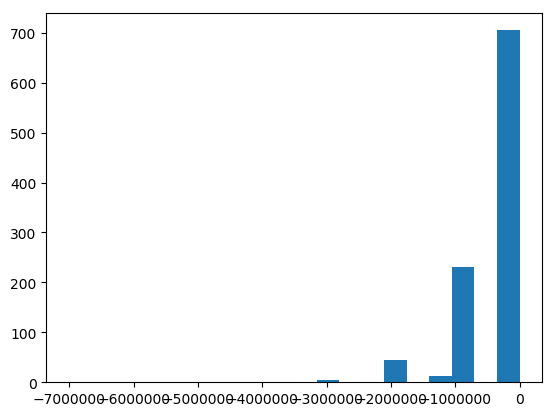

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()
#test_rewards_list

In [15]:
# Visualizing test simulation:
test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())



IndexError: list index out of range

In [ ]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
print(np.mean(test_rewards_list) )

plt.show()

In [ ]:
# Visualizing train simulation:

# train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
# HTML(train_anim.to_html5_video())

episode =11000
simulation_id = 18
step = 30
discrewards_list = ut.load_obj("discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
             discrewards_list2)

#print(discrewards_list) 
plt.show()

In [ ]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))

In [ ]:
list(range(0,len(discrewards_list),1000))

In [ ]:
len(system.tanks_level[0])

In [ ]:
Q

In [ ]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]


In [ ]:
plt.plot(tank_levels)
plt.show()